In [22]:
#input is a strategy, like a repair sequence
#loop
#spend time, repair a node, assume repair is instant
#accumulate and compute resilience triangle
#re-check the functioning bus nodes if the repaired node is a bus node
#change the network parameters and re-run the model
#until sequence end

#repair sequence is some sequence of all broken links and bus
#use heuristic to find out the optimum solution


#this is a test comment
from power_util import delete_buses
from power_util import get_functional_nodes
from road_util import capacity_adjustment
from road_util import eval_tot_OD_travel_time
from interdependency import power_to_road
from run_tapb import run_tapb
from interdependency import repair_path_time
from plot_resilience import plot_triangles_seperate,plot_triangle_tot
import random
from deap import base, creator, tools, algorithms
import itertools
import os
from datetime import datetime
import shutil
import time

power_road_factor=0.5
broken_link_factor=0


def load_disrupted_scenatio(broken_buses,broken_links):
    unfunctional_nodes = delete_buses(broken_buses)
    capacity_adjustment(Org_network,Network1,broken_links,broken_link_factor) #delete link equal to change capacity into 0
    power_to_road(unfunctional_nodes,Network1,Network2,power_road_factor)   #This will edit the capacity of roadway link due to traffic light
    files=[]
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")[:23]
    os.makedirs(backup_dir, exist_ok=True)
    #backup_filepath=backup_dir+timestamp
    #shutil.copy2(Network2, backup_filepath)
    #files.append(timestamp)
    if os.path.exists('s.txt'):
        os.remove('s.txt')
    run_tapb(Network2,'tap-b/net/SiouxFalls_trips.txt') # 1. fix newest folder issue, #2 this is ugly now, change to parameters input later
    #shutil.copy2('flows.txt', backup_filepath+'flows.txt')
    if os.path.exists(Network2):
        os.remove(Network2)
    return files

def eval_road_resilience(broken_buses,broken_links):
    load_disrupted_scenatio(broken_buses,broken_links)
    #total travel time full Sioux Falls network:7,475,338
    return 7475338/eval_tot_OD_travel_time() 

def eval_power_resilience(broken_buses):
    # This represents "unsatisfied demand" 
    return 1-len(delete_buses(broken_buses))/33

def resilience_triangle(functionality,time):
    #求解若干个梯形面积之和
    #implement financial measures for different weights
    complement=0
    functionality_for_triangle=functionality+[1]
    for i in range(len(functionality)):
        complement+=(1-functionality_for_triangle[i]+1-functionality_for_triangle[i+1])*time[i]/2
    return complement

def resilience_evaluation(repair_seq):
    #This gives resilience "triangle"
    repair_seq=repair_seq.copy()
    resilience_road=[]
    resilience_power=[]
    time=[]
    net_file_names=[]
    previous_node=13
    while len(repair_seq)>0:
        broken_buses=[]
        broken_links=[]
        for item in repair_seq:
            if isinstance(item,int):
                broken_buses.append(item)
            else:
                broken_links.append(item)
        #take road output and read travel time, give number
        resilience_road.append(eval_road_resilience(broken_buses,broken_links))
        #take power output and give number
        resilience_power.append(eval_power_resilience(broken_buses))
        #repair and continue
        current_node,current_move_time=repair_path_time('s.txt',repair_seq[0],previous_node)
        time.append(current_move_time) 
        broken_buses=[bus for bus in broken_buses if bus!=repair_seq[0]]
        broken_links=[link for link in broken_links if link!=repair_seq[0]]
        #set up for next loop
        previous_node=current_node
        repair_seq.pop(0)
        #net_file_names.append(load_disrupted_scenatio(broken_buses,broken_links))
    full_resilience = resilience_triangle(resilience_road,time)+resilience_triangle(resilience_power,time)
    return full_resilience, resilience_road,resilience_power,time,net_file_names

###########################################################################################
#This is for the comparison between optimal considering interdependency and repair by type
##########################################################################################
def cxOrderedGrouped(ind1, ind2):
    """执行有序交叉 (Order Crossover, OX)，确保不产生重复元素且保持元组和整数的分组顺序。"""
    # Split individuals into tuple and int groups
    tuples_ind1 = [x for x in ind1 if isinstance(x, tuple)]
    ints_ind1 = [x for x in ind1 if isinstance(x, int)]
    tuples_ind2 = [x for x in ind2 if isinstance(x, tuple)]
    ints_ind2 = [x for x in ind2 if isinstance(x, int)]
    
    # Apply order crossover to tuples and ints separately
    def order_crossover(part1, part2):
        size = len(part1)
        a, b = sorted(random.sample(range(size), 2))
        
        child1 = [None] * size
        child2 = [None] * size
        
        # Copy the crossover slice from the first parent to the first child
        child1[a:b + 1] = part1[a:b + 1]
        child2[a:b + 1] = part2[a:b + 1]
        
        # Fill the remaining positions with the other parent's elements
        fill_pos1, fill_pos2 = (b + 1) % size, (b + 1) % size
        for i in range(size):
            pos = (b + 1 + i) % size
            if part2[pos] not in child1:
                child1[fill_pos1] = part2[pos]
                fill_pos1 = (fill_pos1 + 1) % size
            if part1[pos] not in child2:
                child2[fill_pos2] = part1[pos]
                fill_pos2 = (fill_pos2 + 1) % size
        
        return child1, child2
    
    # Perform order crossover for both tuples and integers
    child1_tuples, child2_tuples = order_crossover(tuples_ind1, tuples_ind2)
    child1_ints, child2_ints = order_crossover(ints_ind1, ints_ind2)
    
    # Combine tuples and ints back together
    child1 = child1_tuples + child1_ints
    child2 = child2_tuples + child2_ints
    
    return creator.Individual(child1), creator.Individual(child2)

def mutShuffleIndexesGrouped(individual, indpb):
    """执行突变操作，确保不产生重复元素且保持元组和整数的分组顺序。"""
    # Split individual into tuple and int groups
    tuples_part = [x for x in individual if isinstance(x, tuple)]
    ints_part = [x for x in individual if isinstance(x, int)]
    
    # Shuffle tuples and ints separately
    def shuffle_part(part):
        size = len(part)
        for i in range(size):
            if random.random() < indpb:
                swap_indx = random.randint(0, size - 1)
                part[i], part[swap_indx] = part[swap_indx], part[i]
        return part
    
    shuffled_tuples = shuffle_part(tuples_part)
    shuffled_ints = shuffle_part(ints_part)
    
    # Combine shuffled tuples and ints back together
    shuffled_individual = shuffled_tuples + shuffled_ints
    
    return creator.Individual(shuffled_individual),
###########################################################################################
##########################################################################################
##########################################################################################

def cxOrdered(ind1, ind2):
    """执行有序交叉 (Order Crossover, OX)，确保不产生重复元素"""
    size = len(ind1)
    a, b = sorted(random.sample(range(size), 2))
    
    child1 = [None]*size
    child2 = [None]*size
    
    # Copy the crossover slice from the first parent to the first child
    child1[a:b + 1] = ind1[a:b + 1]
    child2[a:b + 1] = ind2[a:b + 1]

    # Fill the remaining positions with the other parent's elements
    fill_pos1, fill_pos2 = (b + 1) % size, (b + 1) % size
    for i in range(size):
        pos = (b + 1 + i) % size
        if ind2[pos] not in child1:
            child1[fill_pos1] = ind2[pos]
            fill_pos1 = (fill_pos1 + 1) % size
        if ind1[pos] not in child2:
            child2[fill_pos2] = ind1[pos]
            fill_pos2 = (fill_pos2 + 1) % size

    return creator.Individual(child1), creator.Individual(child2)

def mutShuffleIndexes(individual, indpb):
    """执行突变操作，确保不产生重复元素"""
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 1)
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
    return creator.Individual(individual),

def heuristic_find_solution(initial_sequence,consider_interdependence):
    if len(initial_sequence) <= 1:
        raise ValueError("Initial sequence must contain more than one element.")

    if hasattr(creator, 'FitnessMin'):
        del creator.FitnessMin
    if hasattr(creator, 'Individual'):
        del creator.Individual
    # 创建最小化适应度类
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # 定义个体的生成规则
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: random.sample(initial_sequence, len(initial_sequence)))

    # 定义种群的生成规则
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # 定义适应度函数
    def eval_one_max(individual):
        single_run_time_0=datetime.now()
        fitness = resilience_evaluation(individual)[0]
        single_run_time=datetime.now()-single_run_time_0
        #print(f"Individual: {individual}, Fitness: {fitness}, Duration: {single_run_time}")  # 调试输出
        return (fitness,)

    toolbox.register("evaluate", eval_one_max)

    # 注册遗传算法的操作函数
    if consider_interdependence==True:
        toolbox.register("mate", cxOrdered)
        toolbox.register("mutate", mutShuffleIndexes, indpb=0.2)
    else:
        toolbox.register("mate", cxOrderedGrouped)
        toolbox.register("mutate", mutShuffleIndexesGrouped, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=7)

    # 初始化种群
    population = toolbox.population(n=100)
    print("Initial population:")  # 调试输出
    for ind in population[:5]:  # 只打印前5个个体
        print(ind)
    
    # 定义遗传算法的参数
    NGEN = 20  # 迭代次数
    CXPB = 0.5  # 交叉概率
    MUTPB = 0.2  # 突变概率
    
    # 记录日志
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: sum([a[0] for a in x])/len(x))
    stats.register("min", min)
    stats.register("max", max)

    # 运行遗传算法
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, 
                        stats=stats, verbose=True)
    
    # 找到最优个体
    best_ind = tools.selBest(population, 10)[0]
    with open("ans.txt", 'w') as file:
        file.writelines(str(best_ind))
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind

run_start_time=datetime.now()
#To be replaced by relative references
Exp_folder='Experiment/'
Org_network=Exp_folder+"SiouxFalls_net.txt"
Network1 = Exp_folder + "SiouxFalls_net_link_delete.txt"
Network2 = Exp_folder+"SiouxFalls_net_use.txt"
backup_dir=Exp_folder+"Backup_nets/"
result_folder=Exp_folder+ datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'/'
os.makedirs(result_folder, exist_ok=True)
#To be replaced by random generated ones
#broken_bus_init=[11,17]
#broken_links_init=[(8,9),(9,8),(24,21),(21,24)]
sequence=[11,17,15,(9,10),28,32,(11,14)]
#print(resilience_evaluation([9,8,6,1,6,3,3]))

"""
#####################debug session###################################
myind=[(9, 10), 28, 11, 17, 15, 32, (11, 14)]
result_opt, road_opt, power_opt, time_opt,net_files=resilience_evaluation(myind)
plot_triangles_seperate(road_opt,power_opt,time_opt,result_folder+'test')
plot_triangle_tot(road_opt,power_opt,time_opt,result_folder+'test')
with open(result_folder+'output_test.txt', 'w') as f:
    print("This is optimal considering interdependence", file=f)
    print(myind, file=f)
    print("total complement resilience(not average): ", result_opt, file=f)
    print("road resilience: ", road_opt, file=f)
    print("power resilience: ", power_opt, file=f)
    print("time steps: ", time_opt, file=f)
    print("net files: ", net_files, file=f)
    print()
exit()
"""

def run_model(sequence,bool_stream,result_folder,message,Scenario,plot_control):
    if os.path.exists('bus_location.json'):
        os.remove('bus_location.json')
    if os.path.exists('bus_to_link.json'):
        os.remove('bus_to_link.json')   
    if Scenario[-5:]=='SENS4':
        shutil.copy2('SENS4_bus_to_link_new.json', 'bus_to_link.json')
    else:
        shutil.copy2('new_bus_to_link.json', 'bus_to_link.json')
    if Scenario[-5:]=='SENS2':
        shutil.copy2('SENS4_bus_location.json', 'bus_location.json')
    else:
        shutil.copy2('original_bus_location.json', 'bus_location.json')
    run_start_time=datetime.now()
    if Scenario[:4]=='eval':
        myind=sequence
        print("eval")
    else:
        myind=heuristic_find_solution(sequence,bool_stream)
    #myind=sequence #this is used for debug

    run_end_time=datetime.now()
    duration=run_end_time - run_start_time
    #seperate final back up nets with others

    result_opt, road_opt, power_opt, time_opt,net_files=resilience_evaluation(myind)
    if plot_control==True:
        #for the best solution, draw the resilience triangle
        plot_triangles_seperate(road_opt,power_opt,time_opt,result_folder+Scenario)
        plot_triangle_tot(road_opt,power_opt,time_opt,result_folder+Scenario)
    with open(result_folder+'output.txt', 'a') as f:
        print(message, file=f)
        print(myind, file=f)
        print("run duration: " + str(duration), file=f)
        print("total complement resilience(not average): ", result_opt, file=f)
        print("road resilience: ", road_opt, file=f)
        print("power resilience: ", power_opt, file=f)
        print("time steps: ", time_opt, file=f)
        print("-------------------------------------------------------------------------",file=f)
        print()

    return myind,road_opt,power_opt,time_opt

The following is the random model

eval


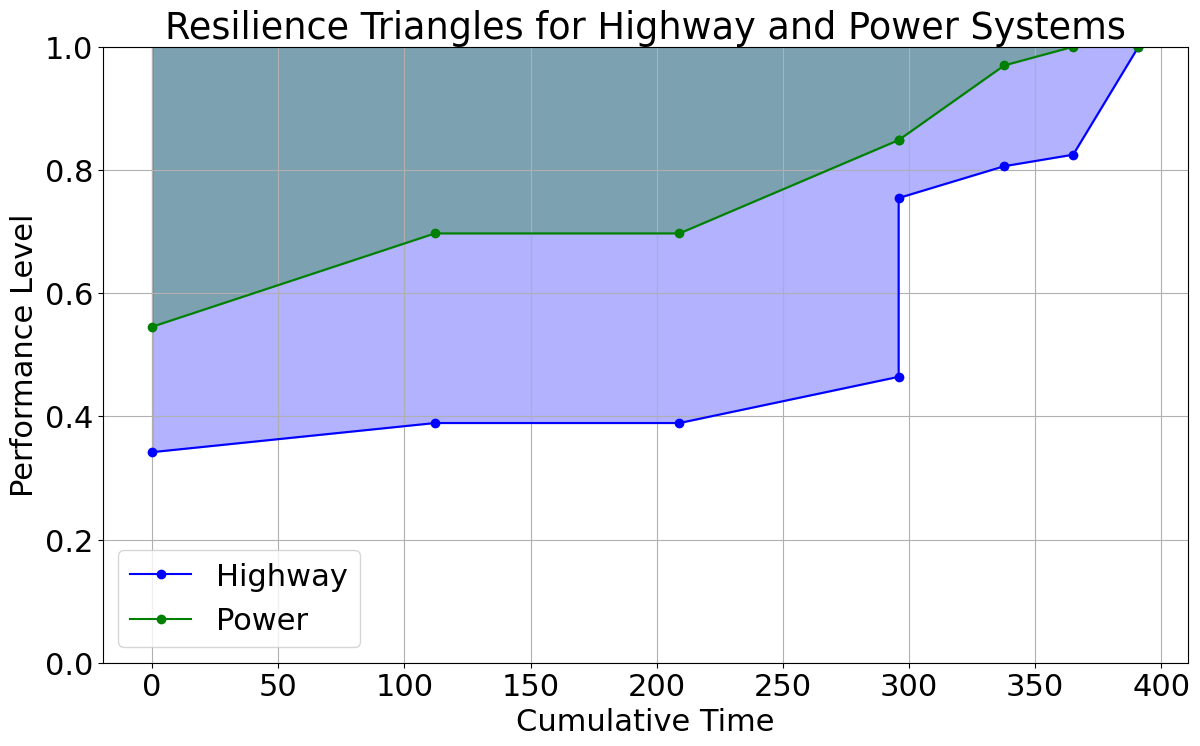

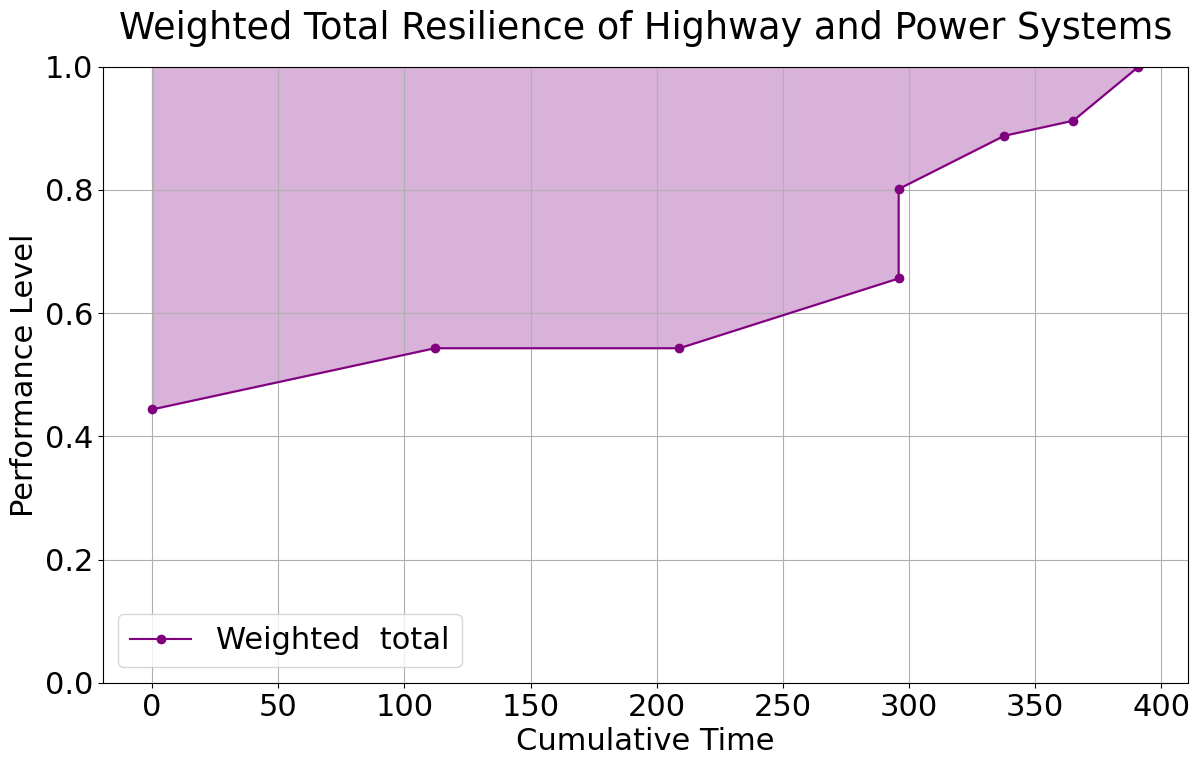

In [23]:
seq_default_random,roadres_default_random,powerres_default_random,time_default_random=run_model(sequence,True,result_folder,"This is random",'evalrand',True)   #consider default sequence as random

The following is the default model

Initial population:
[11, 28, (9, 10), (11, 14), 15, 17, 32]
[15, 28, 32, 11, (9, 10), (11, 14), 17]
[(9, 10), 15, 17, (11, 14), 32, 11, 28]
[15, (11, 14), 28, 32, 11, 17, (9, 10)]
[17, 32, (11, 14), (9, 10), 11, 15, 28]
gen	nevals	avg    	min                 	max                 
0  	100   	260.869	(123.9280555329425,)	(467.5672453370563,)
1  	63    	182.296	(121.67239378764674,)	(362.2354359463675,)
2  	54    	155.188	(114.47549353431225,)	(335.1894283414132,)
3  	68    	154.974	(114.47549353431225,)	(399.07213396204986,)
4  	54    	149.157	(109.93299109934604,)	(383.0157974397726,) 
5  	60    	133.767	(109.93299109934604,)	(344.1617060809833,) 
6  	56    	130.897	(109.93299109934604,)	(328.1108061671083,) 
7  	56    	130.286	(109.93299109934604,)	(289.63308496743593,)
8  	64    	134.519	(109.93299109934604,)	(371.57259195039495,)
9  	56    	133.96 	(109.87755795151386,)	(476.7268042680366,) 
10 	63    	122.531	(109.87755795151386,)	(291.4306136133386,) 
11 	56    	128.691	(109.877557

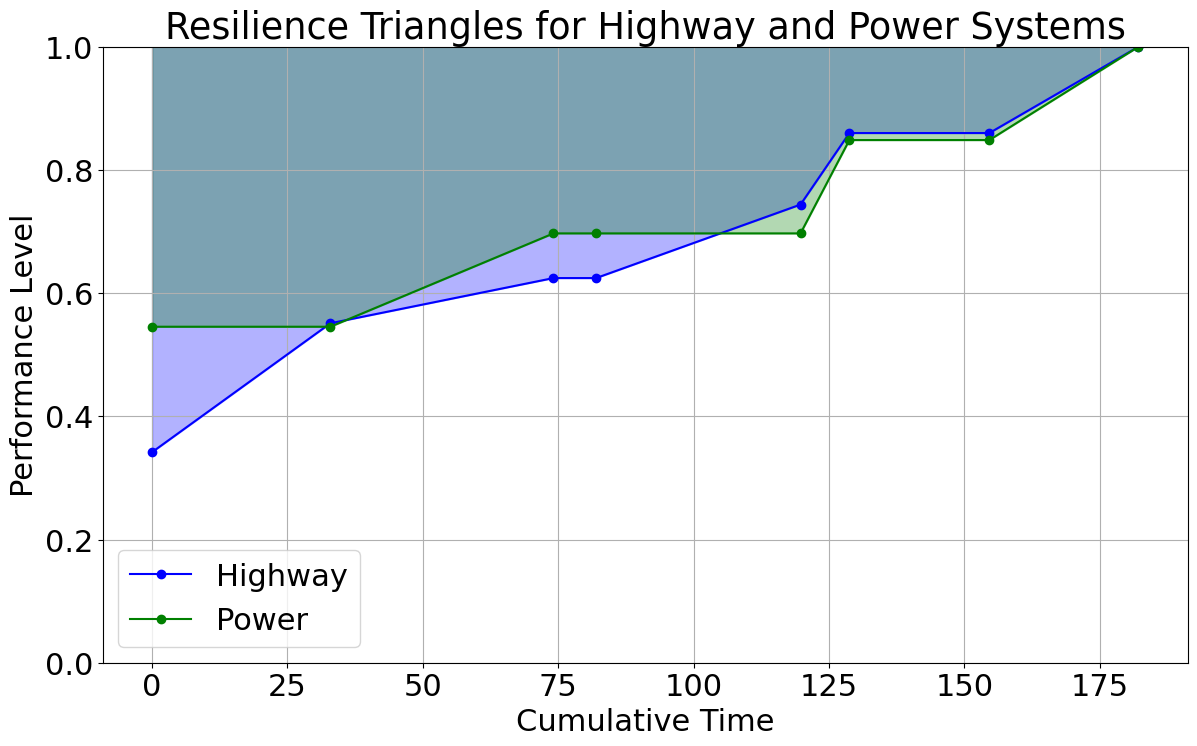

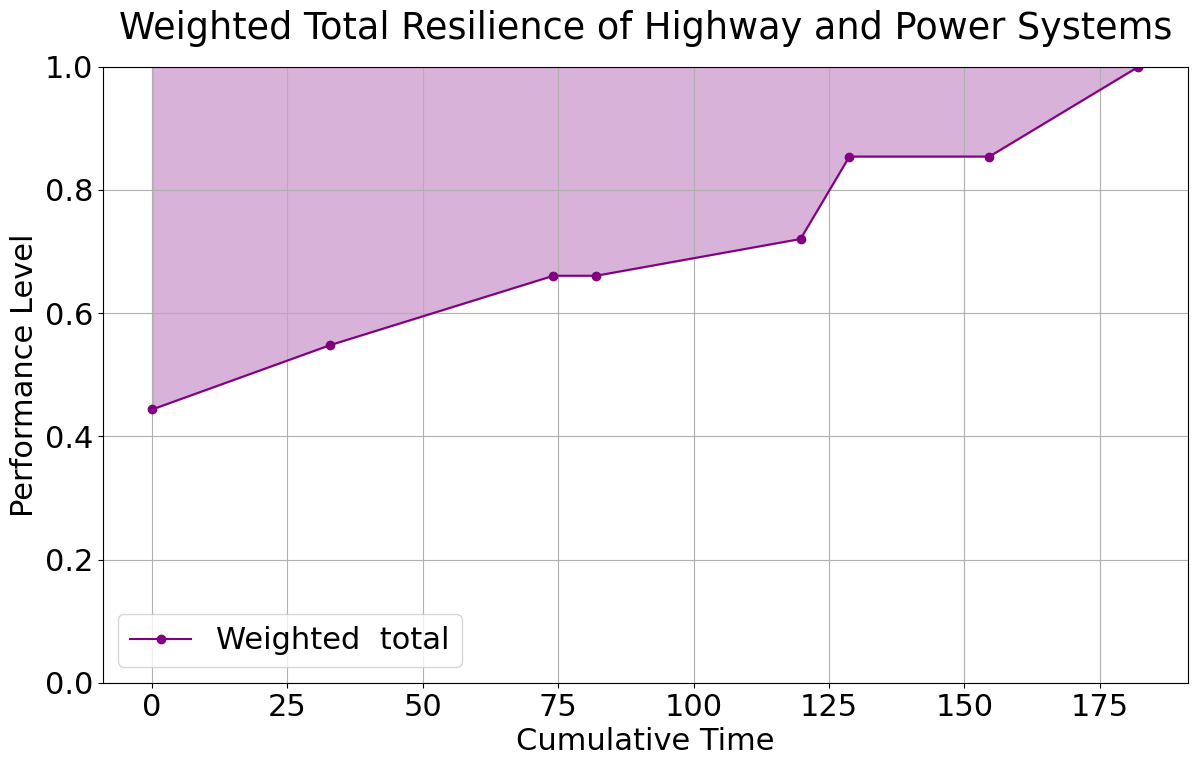

In [24]:
seq_default_opt,roadres_default_opt,powerres_default_opt,time_default_opt=run_model(sequence,True,result_folder,"This is optimal considering interdependence",'opt',True)

In [25]:
powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only",'optPower',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only",'optRoad',False)[0]
road_priority=roads_ans+power_ans
power_priority=power_ans+roads_ans

Initial population:
[11, 17, 28, 15, 32]
[17, 15, 11, 32, 28]
[15, 11, 17, 32, 28]
[17, 32, 15, 28, 11]
[11, 32, 15, 28, 17]
gen	nevals	avg    	min                 	max                  
0  	100   	95.1076	(50.17976264511683,)	(166.41600110371922,)
1  	55    	67.702 	(50.17976264511683,)	(107.07154707991425,)
2  	70    	59.2694	(50.17976264511683,)	(137.30250809175948,)
3  	55    	53.5319	(50.17976264511683,)	(109.9025774954251,) 
4  	57    	55.5054	(50.17976264511683,)	(126.37087382969972,)
5  	57    	56.3216	(50.17976264511683,)	(110.32730513236041,)
6  	48    	52.7097	(50.17976264511683,)	(96.73293123421108,) 
7  	50    	52.1823	(50.17976264511683,)	(96.73293123421108,) 
8  	63    	54.1098	(50.17976264511683,)	(115.84984042624961,)
9  	63    	53.9428	(50.17976264511683,)	(170.37609067031232,)
10 	52    	52.8545	(50.17976264511683,)	(109.9025774954251,) 
11 	54    	54.6307	(50.17976264511683,)	(137.30250809175948,)
12 	71    	53.5449	(50.17976264511683,)	(99.15038984969298,) 
13 	59 

Road Priority

eval


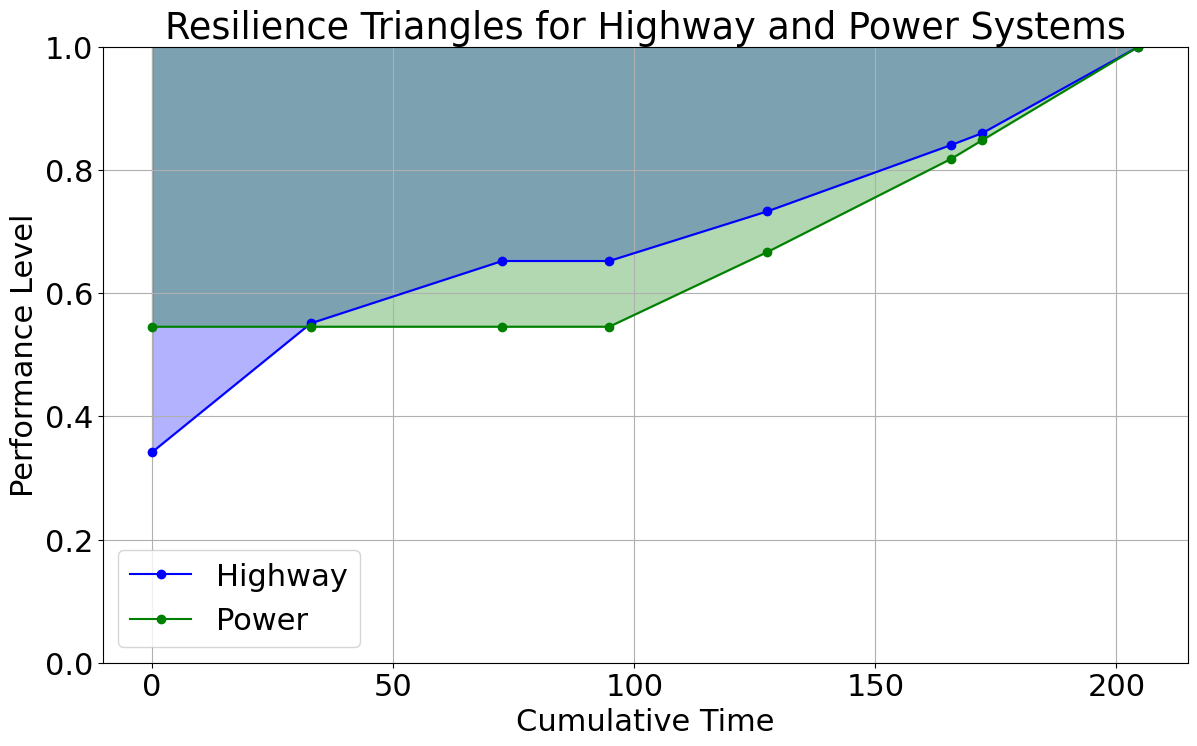

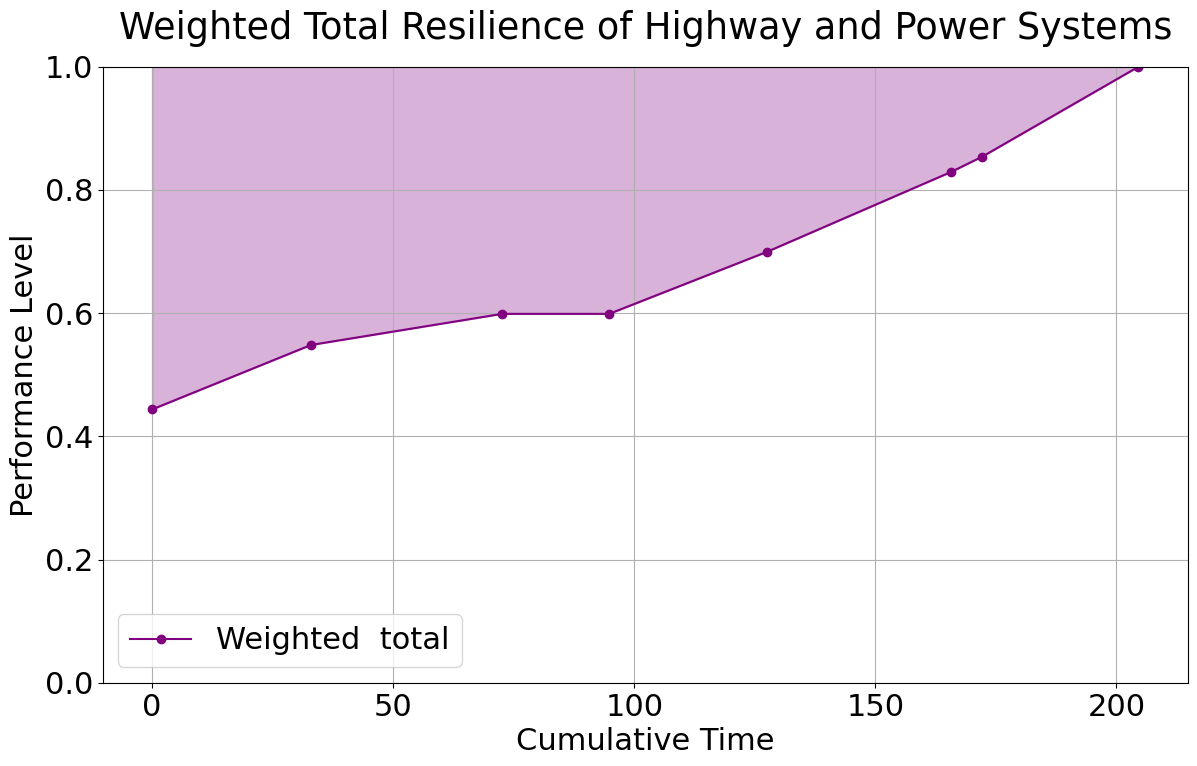

In [26]:
seq_default_roadpri,roadres_default_roadpri,powerres_default_roadpri,time_default_roadpri=run_model(road_priority,True,result_folder,"This is Road priority",'evalRoadPriority',True)

Power Priority

eval


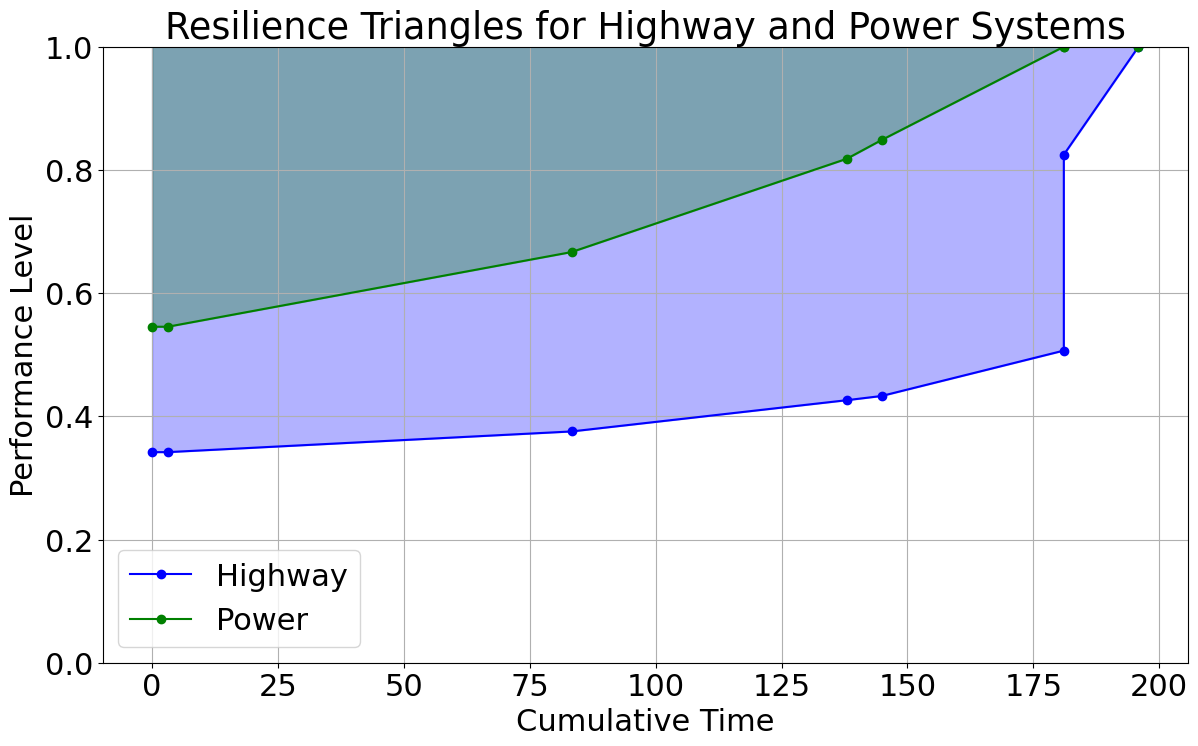

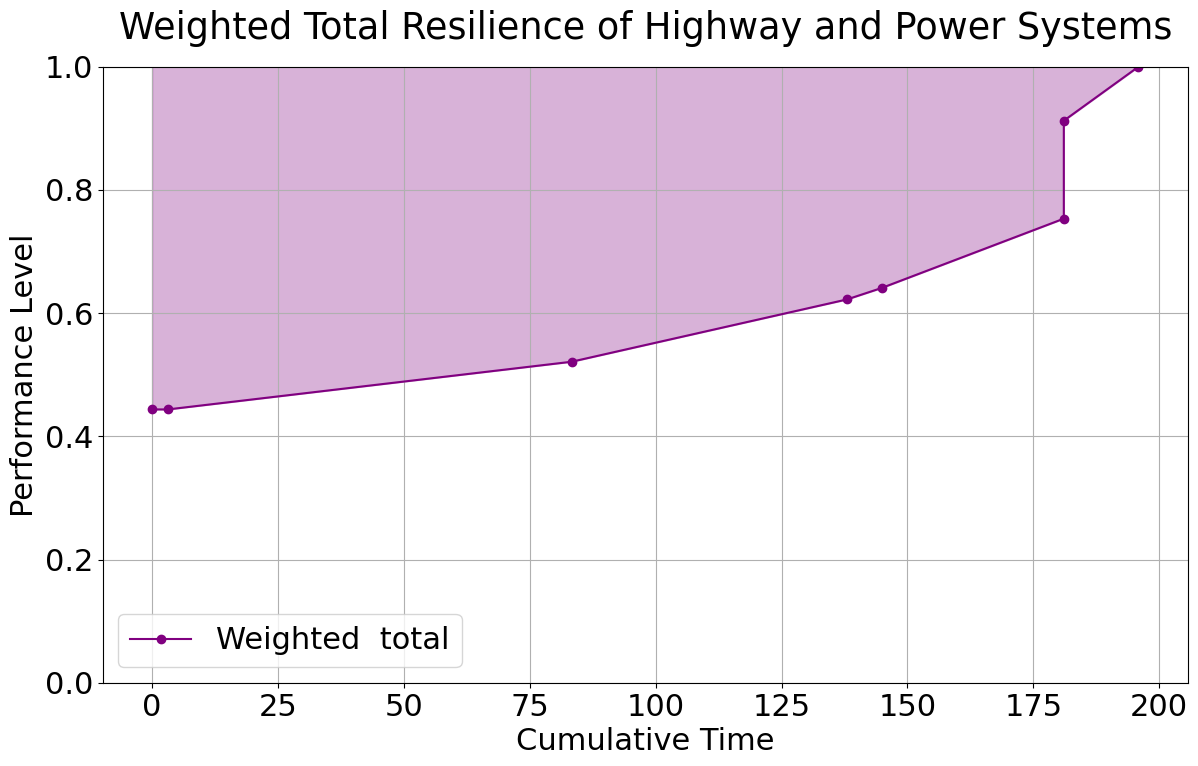

In [27]:
seq_default_powerpri,roadres_default_powerpri,powerres_default_powerpri,time_default_powerpri=run_model(power_priority,True,result_folder,"This is Power priority",'evalPowerPriority',True)

Sensitivity design
Sensitivity #1: 
increase the number of broken links/nets

eval


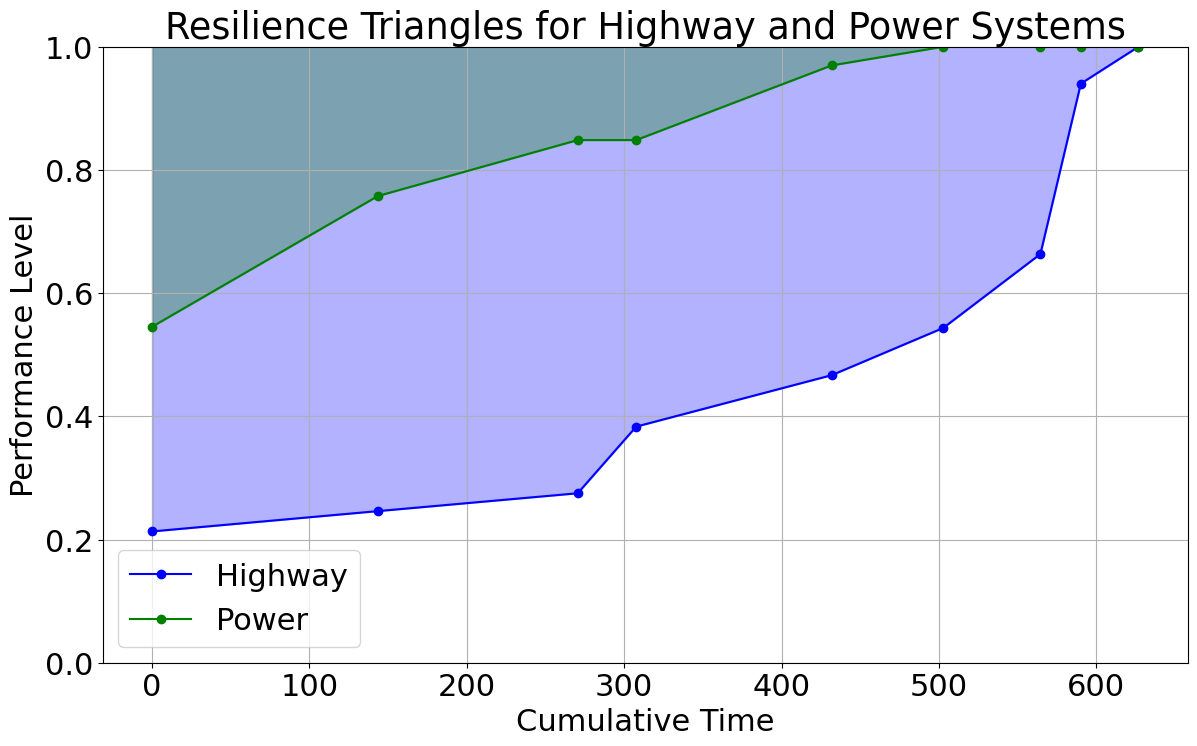

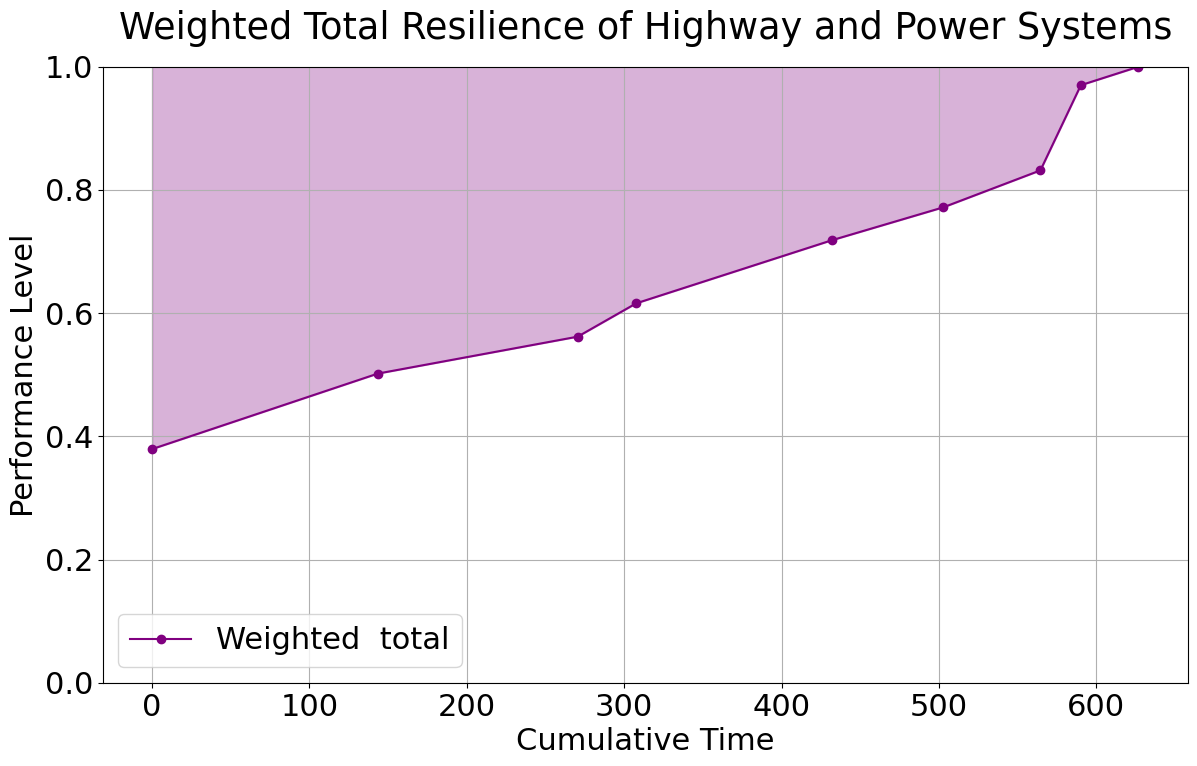

([11, 17, (9, 10), 28, 32, (11, 14), (15, 22), (2, 6)],
 [0.21316155856246405,
  0.2461306690882686,
  0.2751213327626816,
  0.38329557782935686,
  0.4668381999946067,
  0.5435080699192547,
  0.6635002251910879,
  0.9400822150101154],
 [0.5454545454545454,
  0.7575757575757576,
  0.8484848484848485,
  0.8484848484848485,
  0.9696969696969697,
  1.0,
  1.0,
  1.0],
 [143.414122,
  127.010639,
  37.166496,
  124.270312,
  70.87117,
  61.723168,
  25.681462000000003,
  36.616465000000005])

In [28]:
SENS1_sequence=[11,17,(9,10),28,32,(11,14),(15,22),(2,6)]
run_model(SENS1_sequence,True,result_folder,"This is random of SENSITIVITY increase breaks",'evalrandSENS1',True)

Initial population:
[(2, 6), 32, 11, (15, 22), 28, (9, 10), 17, (11, 14)]
[(9, 10), (2, 6), 11, 17, (11, 14), 32, (15, 22), 28]
[32, 17, 28, 11, (2, 6), (11, 14), (15, 22), (9, 10)]
[32, (2, 6), 11, 17, (15, 22), (9, 10), (11, 14), 28]
[32, 17, 11, (15, 22), 28, (11, 14), (2, 6), (9, 10)]
gen	nevals	avg    	min                 	max                 
0  	100   	410.392	(179.3128314119421,)	(682.4067898498931,)
1  	57    	298.485	(179.3128314119421,)	(586.5963452832798,)
2  	63    	281.28 	(132.6451202741808,)	(567.5430520991449,)
3  	59    	247.897	(132.6451202741808,)	(685.1030382506777,)
4  	66    	212.51 	(132.6451202741808,)	(622.446807295376,) 
5  	56    	175.394	(130.27579431343986,)	(508.6876615121297,)
6  	70    	157.927	(130.27579431343986,)	(448.67343050177874,)
7  	71    	172.856	(129.46812113984203,)	(472.4968566698021,) 
8  	61    	157.272	(129.46812113984203,)	(392.3195388170881,) 
9  	72    	164.194	(129.46812113984203,)	(541.9556174149736,) 
10 	60    	162.298	(129.435867

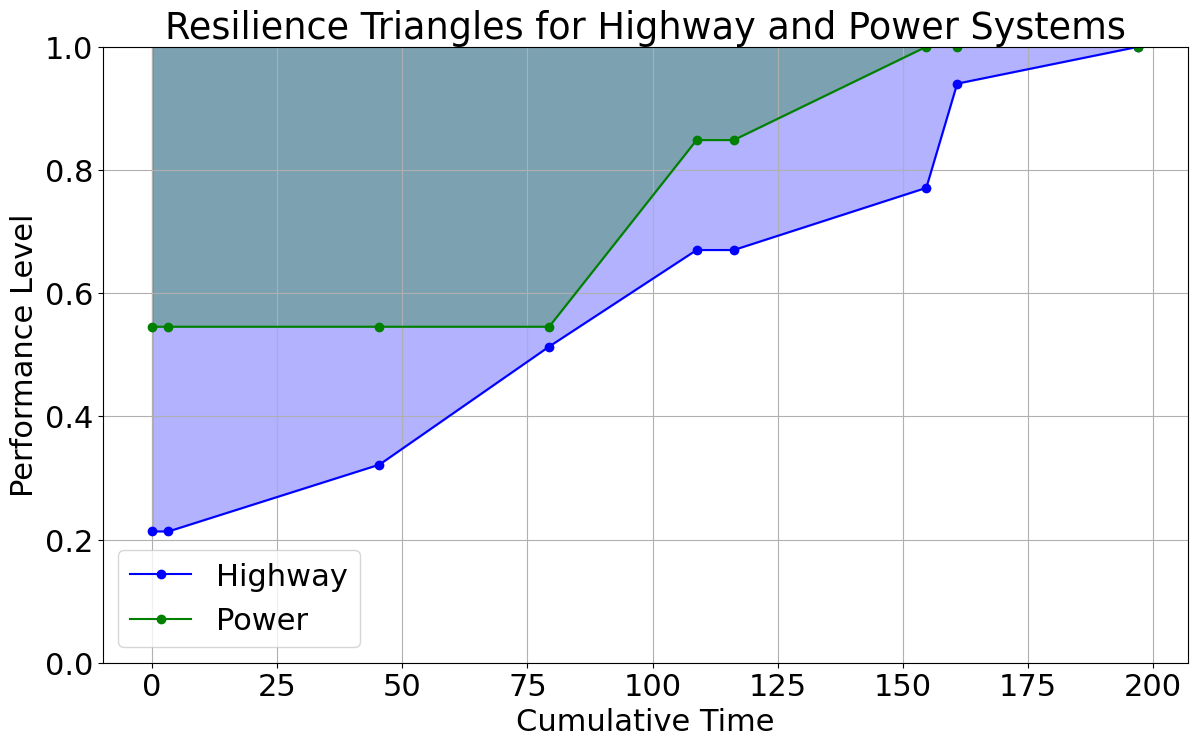

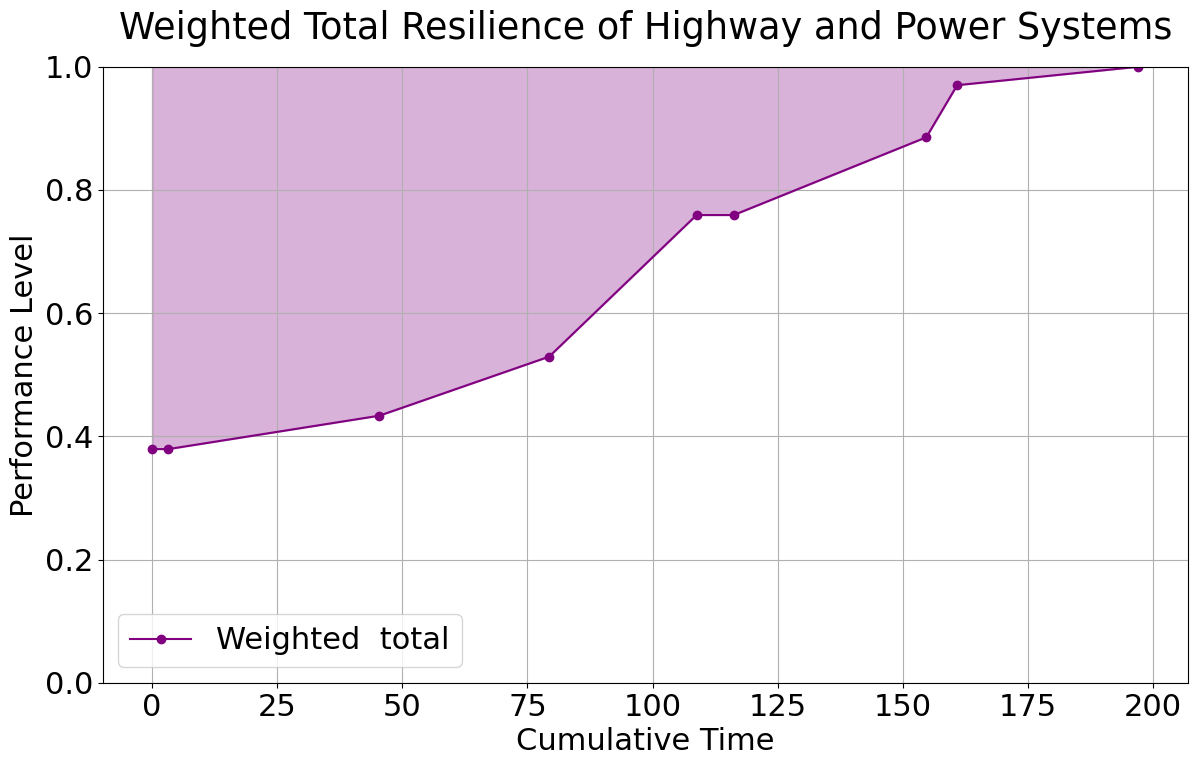

In [29]:
seq_SENS1_opt,roadres_SENS1_opt,powerres_SENS1_opt,time_SENS1_opt=run_model(SENS1_sequence,True,result_folder,"This is SENSITIVITY increase breaks",'SENS1',True)

In [30]:
powers_only_sens1=[11,17,28,32]
roads_only_sens1=[(9,10),(11,14),(15,22),(2,6)]
power_ans_sens1=run_model(powers_only_sens1,True,result_folder,"This is optimal Power only SENS1",'optPowerSENS1',False)[0]
roads_ans_sens1=run_model(roads_only_sens1,True,result_folder,"This is optimal Road only SENS1",'optRoadSENS1',False)[0]
power_priority_sens1=power_ans_sens1+roads_ans_sens1
road_priority_sens1=roads_ans_sens1+power_ans_sens1

Initial population:
[17, 28, 11, 32]
[17, 32, 28, 11]
[32, 28, 17, 11]
[17, 11, 32, 28]
[32, 11, 17, 28]
gen	nevals	avg    	min                  	max                  
0  	100   	70.7897	(38.154815959758636,)	(138.09035618204672,)
1  	61    	46.724 	(38.154815959758636,)	(96.59348125006068,) 
2  	59    	39.5614	(38.154815959758636,)	(63.627877953519146,)
3  	54    	39.8885	(38.154815959758636,)	(76.03131676228861,) 
4  	54    	40.8586	(38.154815959758636,)	(96.59348125006068,) 
5  	65    	40.7237	(38.154815959758636,)	(96.59348125006068,) 
6  	56    	42.0304	(38.154815959758636,)	(138.09035618204672,)
7  	66    	40.9645	(38.154815959758636,)	(96.59348125006068,) 
8  	67    	40.2451	(38.154815959758636,)	(66.26087810942657,) 
9  	53    	41.1282	(38.154815959758636,)	(138.09035618204672,)
10 	56    	40.4546	(38.154815959758636,)	(96.59348125006068,) 
11 	56    	42.1624	(38.154815959758636,)	(96.59348125006068,) 
12 	60    	39.5583	(38.154815959758636,)	(96.59348125006068,) 
13 	54    	43

eval


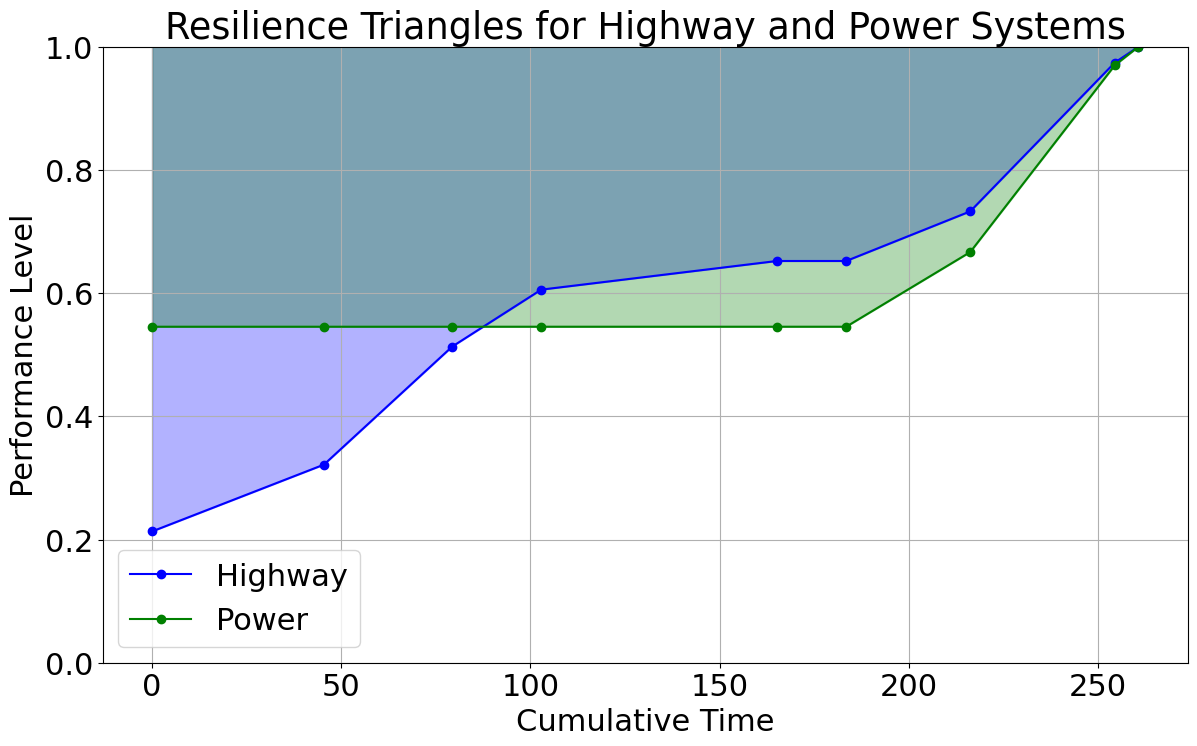

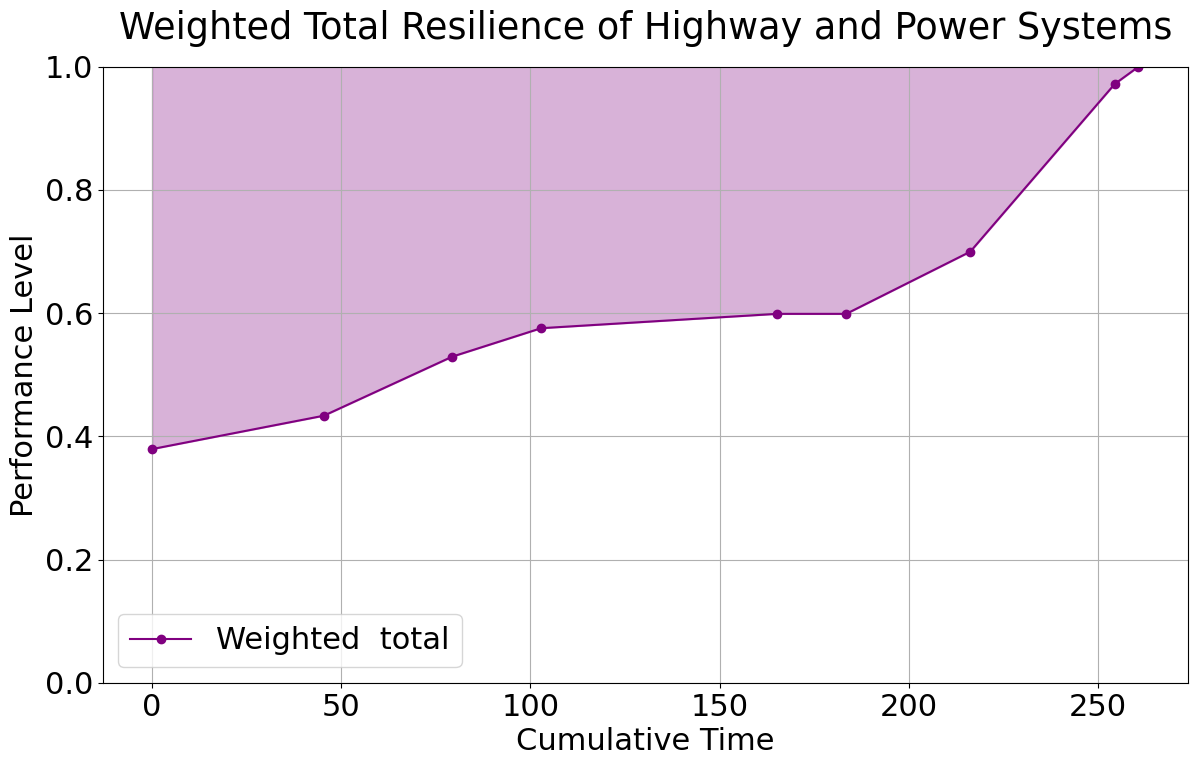

In [31]:
seq_SENS1_roadpri,roadres_SENS1_roadpri,powerres_SENS1_roadpri,time_SENS1_roadpri=run_model(road_priority_sens1,True,result_folder,"This is Road priority SENS1",'evalRoadPrioritySENS1',True)

eval


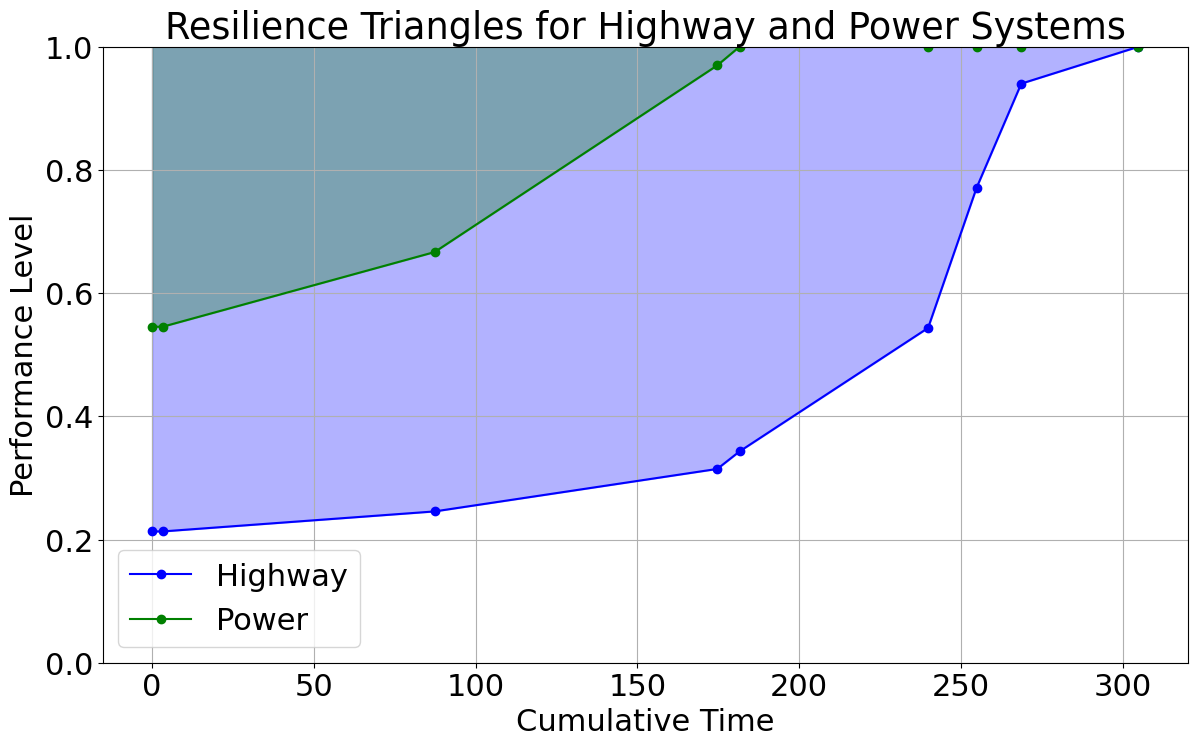

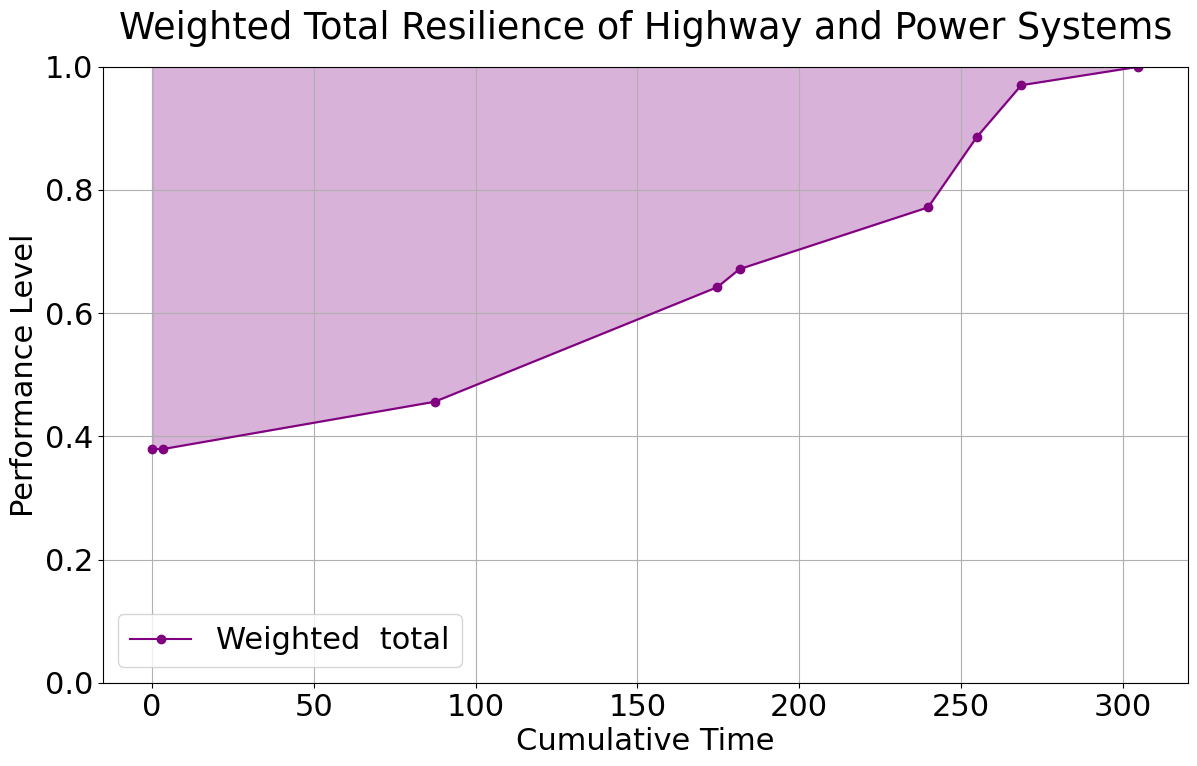

In [32]:
seq_SENS1_powerpri,roadres_SENS1_powerpri,powerres_SENS1_powerpri,time_SENS1_powerpri=run_model(power_priority_sens1,True,result_folder,"This is Power priority SENS1",'evalPowerPrioritySENS1',True)

Sensitivity#2:
move the connection points around

Initial population:
[28, 17, 15, (9, 10), 11, (11, 14), 32]
[15, 11, (11, 14), (9, 10), 32, 17, 28]
[32, (9, 10), 17, 11, 15, (11, 14), 28]
[15, (9, 10), 17, 32, 28, 11, (11, 14)]
[15, 17, 32, (9, 10), 11, (11, 14), 28]
gen	nevals	avg    	min                 	max                 
0  	100   	243.358	(98.26411503908679,)	(460.4525226363603,)
1  	64    	172.146	(88.2882042122528,) 	(365.88164569552106,)
2  	67    	143.354	(88.2882042122528,) 	(412.8030604956232,) 
3  	57    	122.602	(80.6301412640465,) 	(391.8094321701684,) 
4  	70    	113.809	(80.6301412640465,) 	(391.8094321701684,) 
5  	68    	103.396	(80.6301412640465,) 	(391.8094321701684,) 
6  	44    	98.094 	(80.6301412640465,) 	(375.8643535535941,) 
7  	71    	87.3444	(80.6301412640465,) 	(220.7481748070394,) 
8  	61    	96.8932	(80.6301412640465,) 	(341.5928767910606,) 
9  	68    	93.0564	(80.6301412640465,) 	(361.63751382482593,)
10 	54    	86.5682	(80.6301412640465,) 	(233.43319836244194,)
11 	70    	90.7853	(80.6301412640465,)

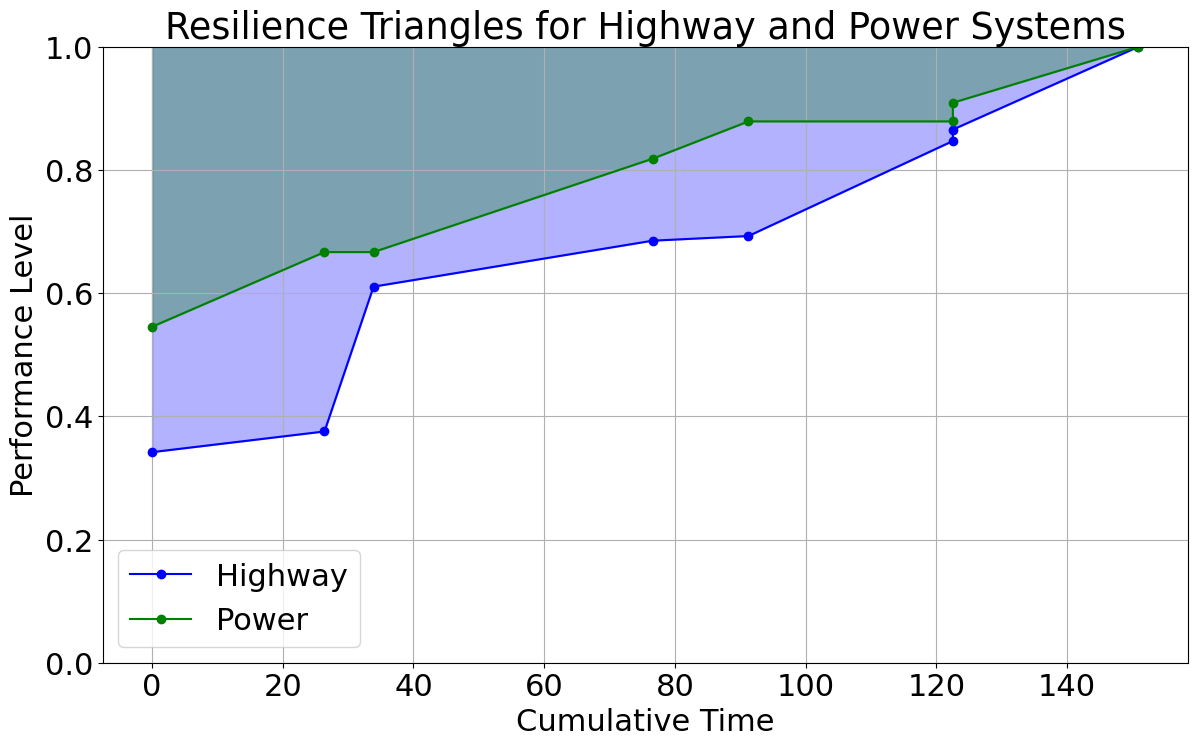

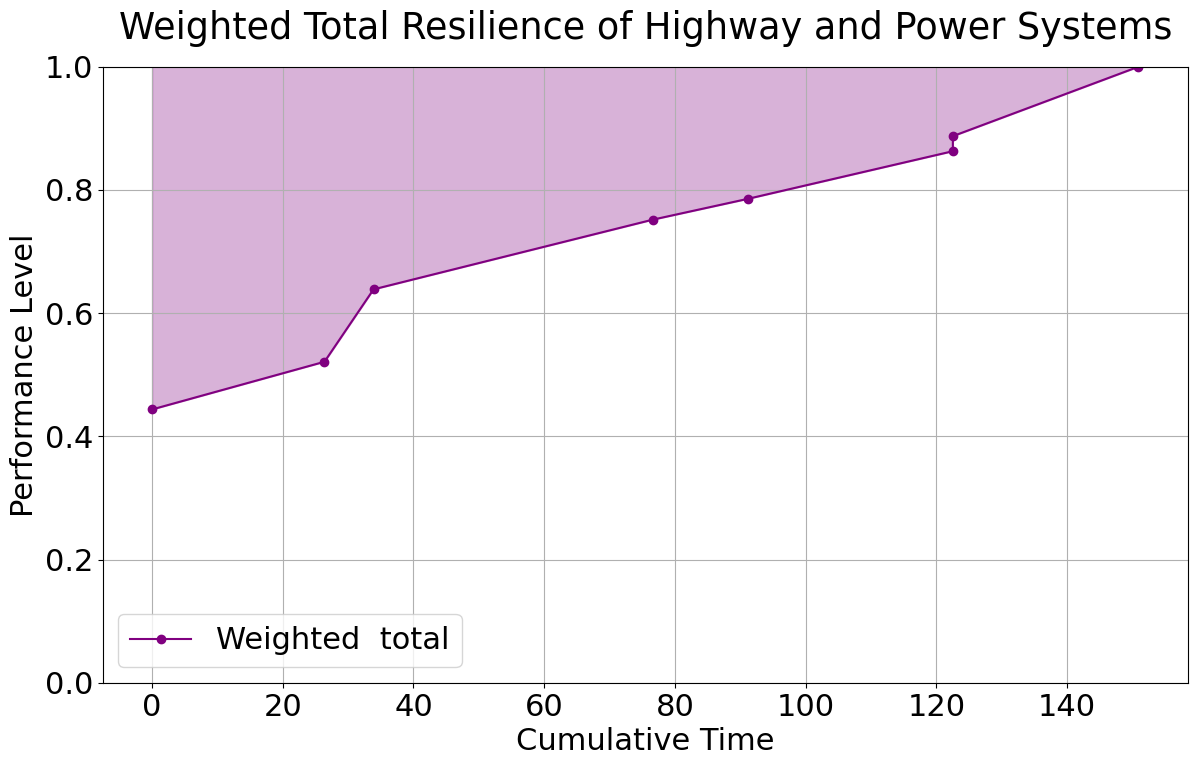

In [33]:
seq_SENS2_opt,roadres_SENS2_opt,powerres_SENS2_opt,time_SENS2_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #2, move connections around",'SENS2',True)

In [34]:
powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS2",'optPowerSENS2',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS2",'optRoadSENS2',False)[0]

Initial population:
[15, 28, 11, 32, 17]
[15, 17, 32, 28, 11]
[28, 32, 17, 15, 11]
[17, 11, 28, 32, 15]
[11, 15, 32, 28, 17]
gen	nevals	avg    	min                 	max                 
0  	100   	90.8028	(40.89135946410181,)	(150.3616704113395,)
1  	50    	68.3089	(40.89135946410181,)	(128.34563468412475,)
2  	62    	56.5833	(40.89135946410181,)	(114.06101153941205,)
3  	58    	47.7371	(40.89135946410181,)	(119.35449623542978,)
4  	56    	42.9621	(40.89135946410181,)	(100.46186305247274,)
5  	69    	46.1241	(40.89135946410181,)	(116.33790550355945,)
6  	68    	44.617 	(40.89135946410181,)	(132.47997839454752,)
7  	66    	46.4833	(40.89135946410181,)	(112.33560218009845,)
8  	61    	46.6521	(40.89135946410181,)	(100.46186305247274,)
9  	60    	46.1724	(40.89135946410181,)	(104.58976649445123,)
10 	59    	44.8476	(40.89135946410181,)	(97.94287550226505,) 
11 	72    	42.854 	(40.89135946410181,)	(100.01135672734637,)
12 	51    	43.7239	(40.89135946410181,)	(109.41295991904585,)
13 	56   

eval


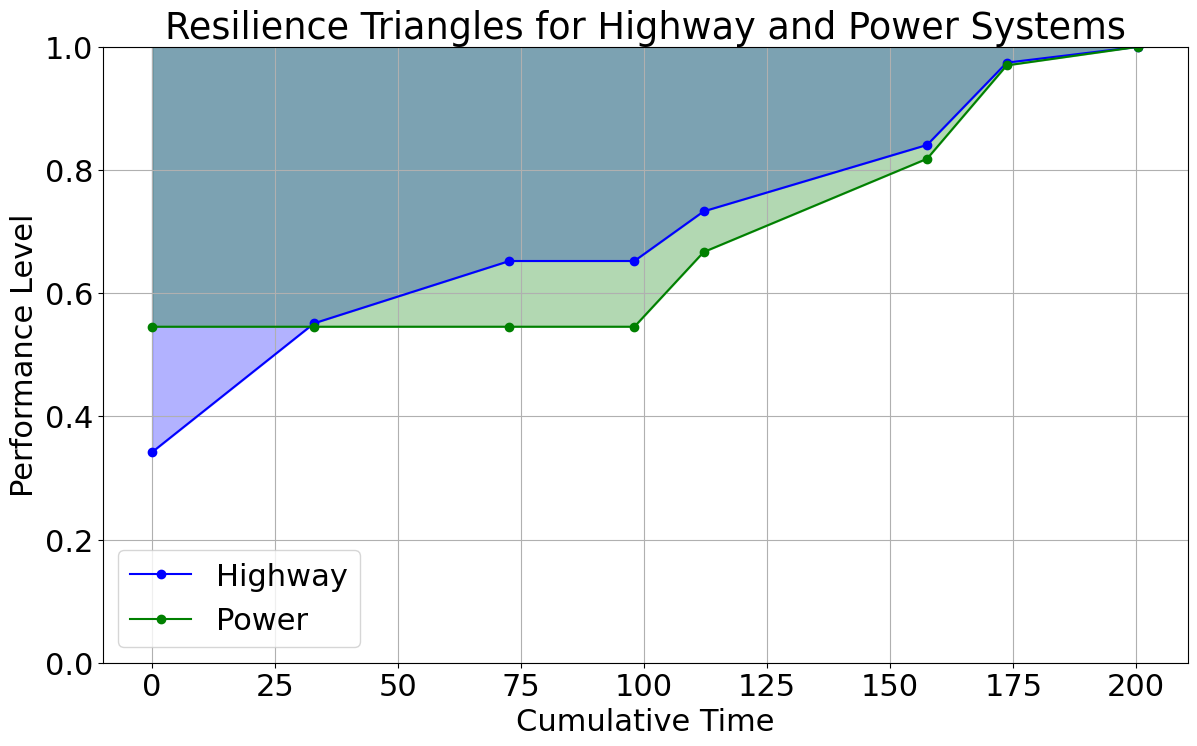

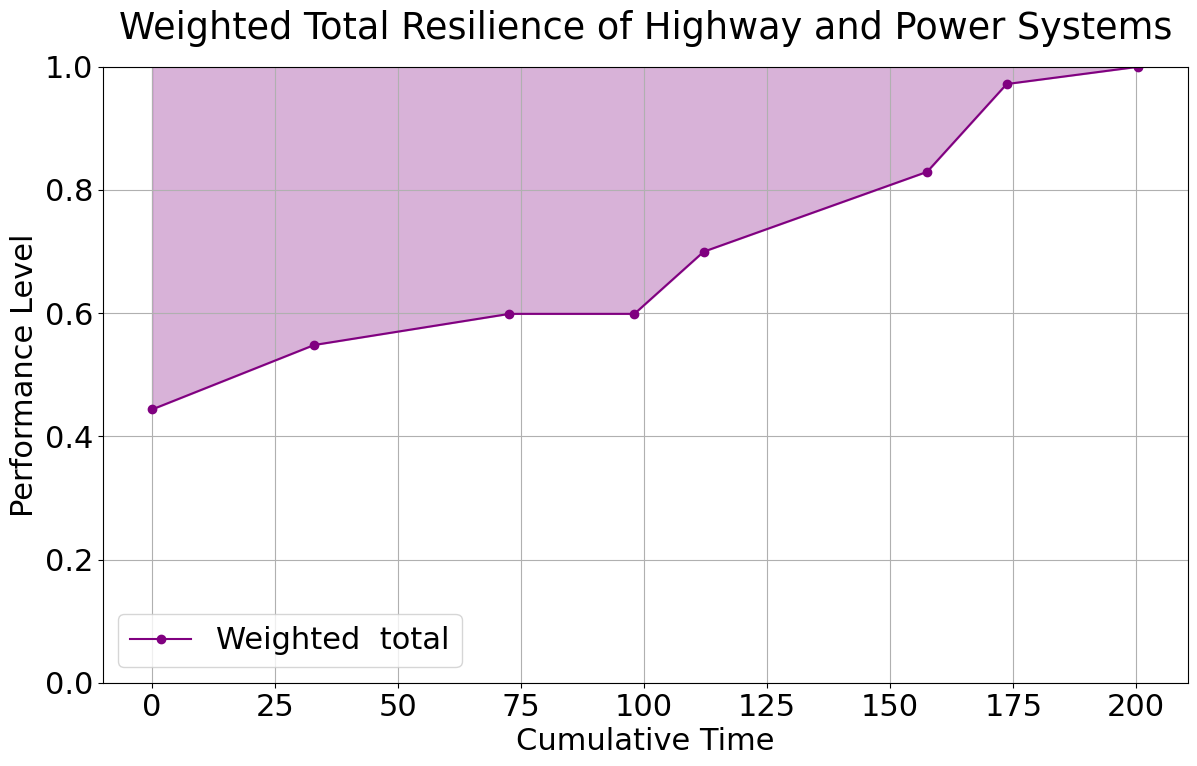

In [35]:
seq_SENS2_roadpri,roadres_SENS2_roadpri,powerres_SENS2_roadpri,time_SENS2_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS2",'evalRoadPrioritySENS2',True)

eval


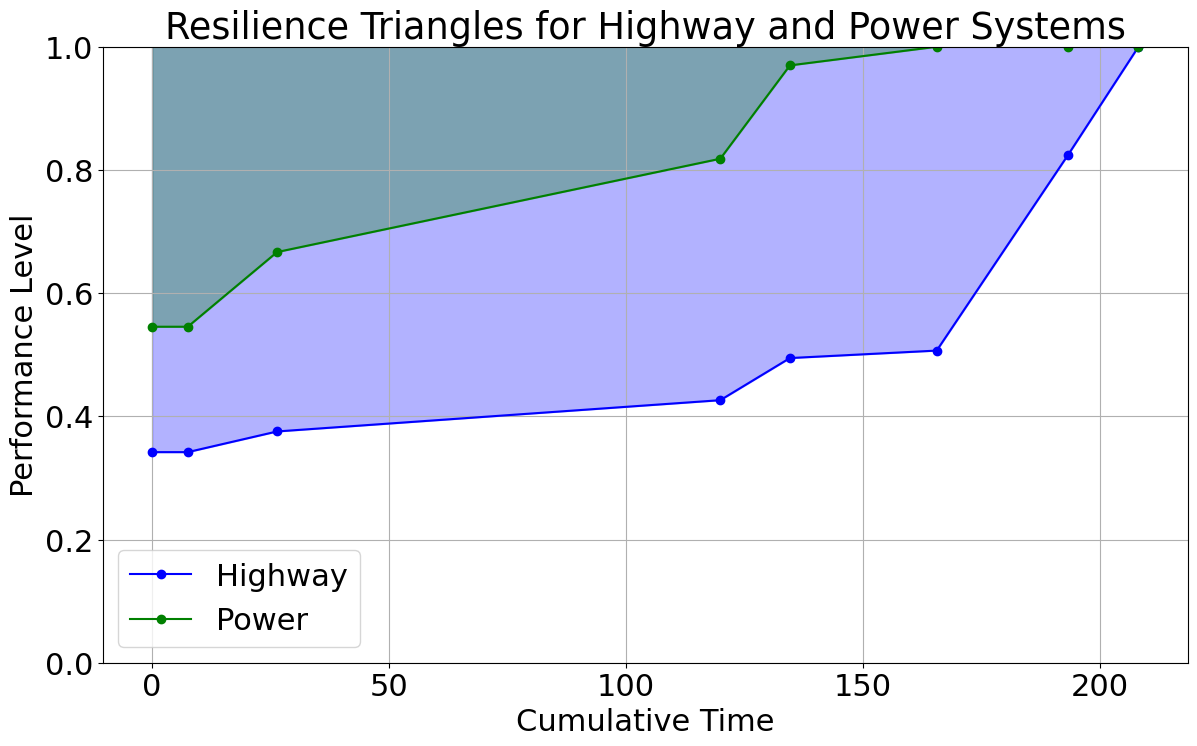

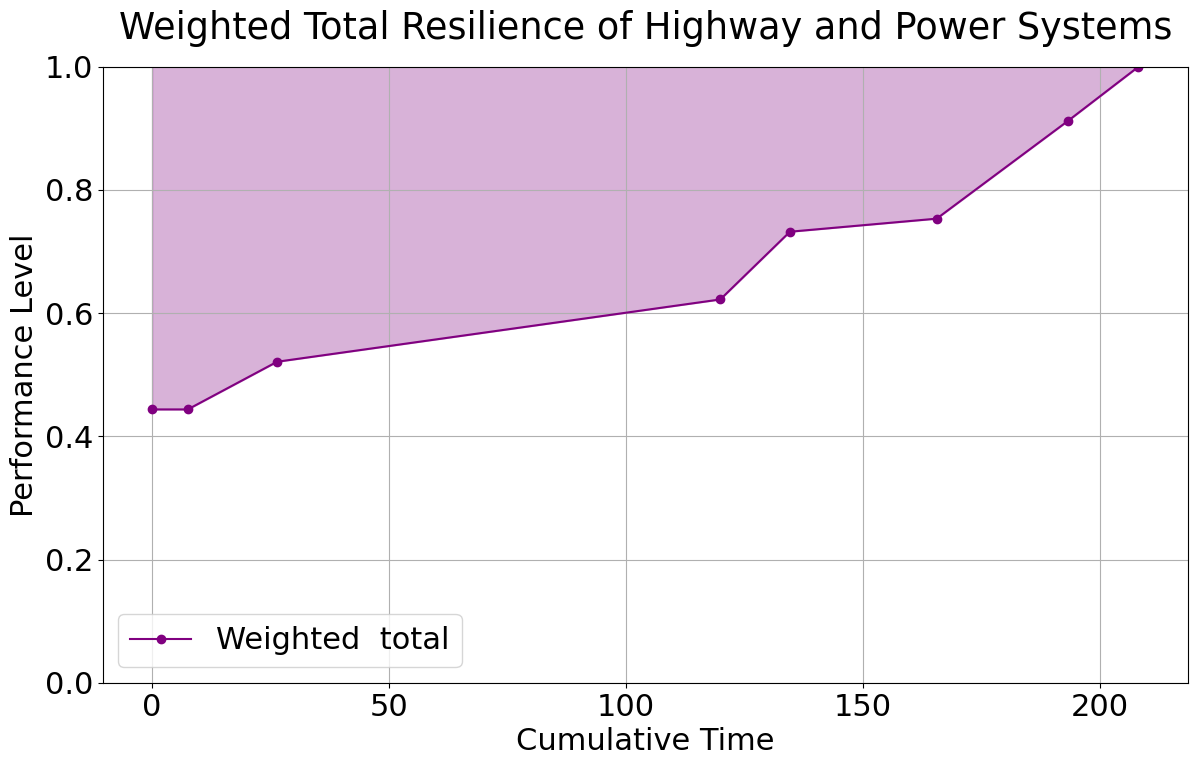

In [36]:
seq_SENS2_powerpri,roadres_SENS2_powerpri,powerres_SENS2_powerpri,time_SENS2_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS2",'evalPowerPrioritySENS2',True)


Sensitivity #3
different harm level for broken net or power fail (interdependency level)

Initial population:
[32, 28, 11, (9, 10), 15, (11, 14), 17]
[28, (9, 10), 15, 32, 17, (11, 14), 11]
[(9, 10), 17, 32, 11, (11, 14), 15, 28]
[11, (9, 10), (11, 14), 28, 32, 17, 15]
[32, 28, 17, 11, (9, 10), (11, 14), 15]
gen	nevals	avg    	min                 	max                 
0  	100   	477.873	(225.4958500814351,)	(958.5747125550517,)
1  	65    	342.224	(218.16638645832262,)	(709.8877273118292,)
2  	63    	300.598	(218.16638645832262,)	(684.1819386159713,)
3  	57    	256.588	(218.16638645832262,)	(556.6881363679438,)
4  	59    	234.094	(218.16638645832262,)	(540.5782796472474,)
5  	60    	237.206	(218.16638645832262,)	(540.5782796472474,)
6  	57    	226.392	(218.16638645832262,)	(588.7464316525542,)
7  	53    	240.054	(218.16638645832262,)	(540.5782796472474,)
8  	62    	246.52 	(218.16638645832262,)	(543.5645343731649,)
9  	70    	237.463	(218.16638645832262,)	(664.2981241932785,)
10 	52    	233.511	(218.16638645832262,)	(642.8340741193877,)
11 	59    	235.09 	(218.16638645832262

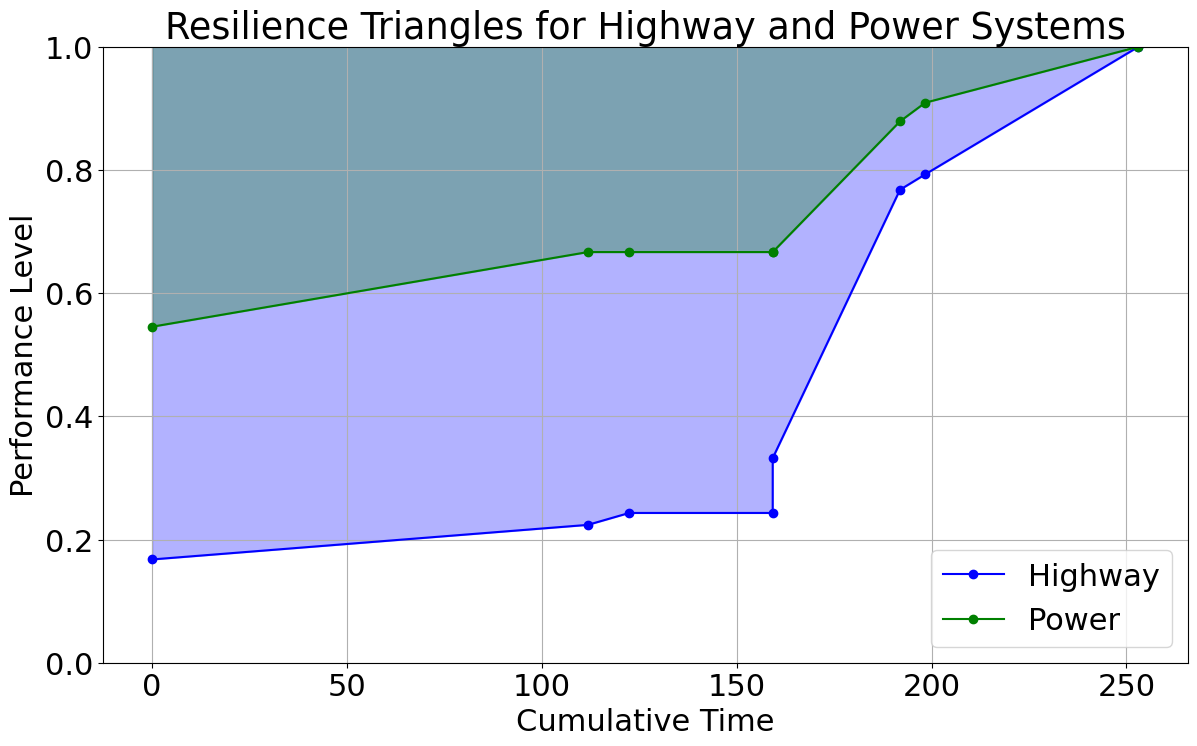

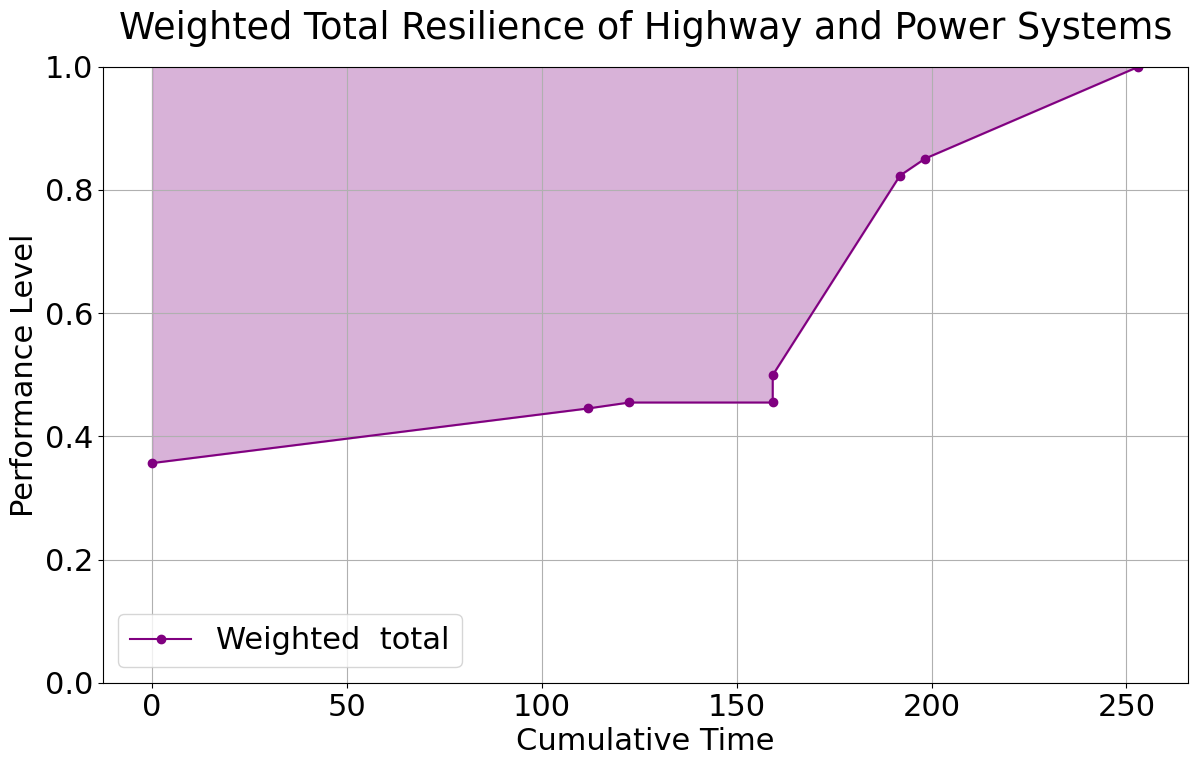

In [37]:
power_road_factor=0.3 #the lower of this the more severe the damage is
seq_SENS3_opt,roadres_SENS3_opt,powerres_SENS3_opt,time_SENS3_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #3, harm level increase",'SENS3',True)

In [38]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS3",'optPowerSENS3',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS3",'optRoadSENS3',False)[0]


Initial population:
[28, 17, 11, 32, 15]
[11, 17, 28, 15, 32]
[32, 17, 28, 15, 11]
[17, 32, 15, 28, 11]
[28, 17, 15, 11, 32]
gen	nevals	avg    	min                  	max                  
0  	100   	210.533	(107.18697401591342,)	(420.26508489680646,)
1  	57    	151.898	(107.18697401591342,)	(363.4275042860424,) 
2  	50    	128.6  	(107.18697401591342,)	(420.26508489680646,)
3  	53    	123.548	(107.18697401591342,)	(361.53929519268945,)
4  	63    	114.099	(107.18697401591342,)	(242.90908671058668,)
5  	62    	112.692	(107.18697401591342,)	(218.42634713192123,)
6  	67    	120.33 	(107.18697401591342,)	(399.11211256346735,)
7  	56    	117.689	(107.18697401591342,)	(257.75034393096746,)
8  	66    	112.57 	(107.18697401591342,)	(252.42783825368957,)
9  	58    	115.026	(107.18697401591342,)	(252.42783825368957,)
10 	49    	118.547	(107.18697401591342,)	(304.81170693564025,)
11 	60    	116.164	(107.18697401591342,)	(278.9852682482274,) 
12 	45    	111.844	(107.18697401591342,)	(216.3201171216

eval


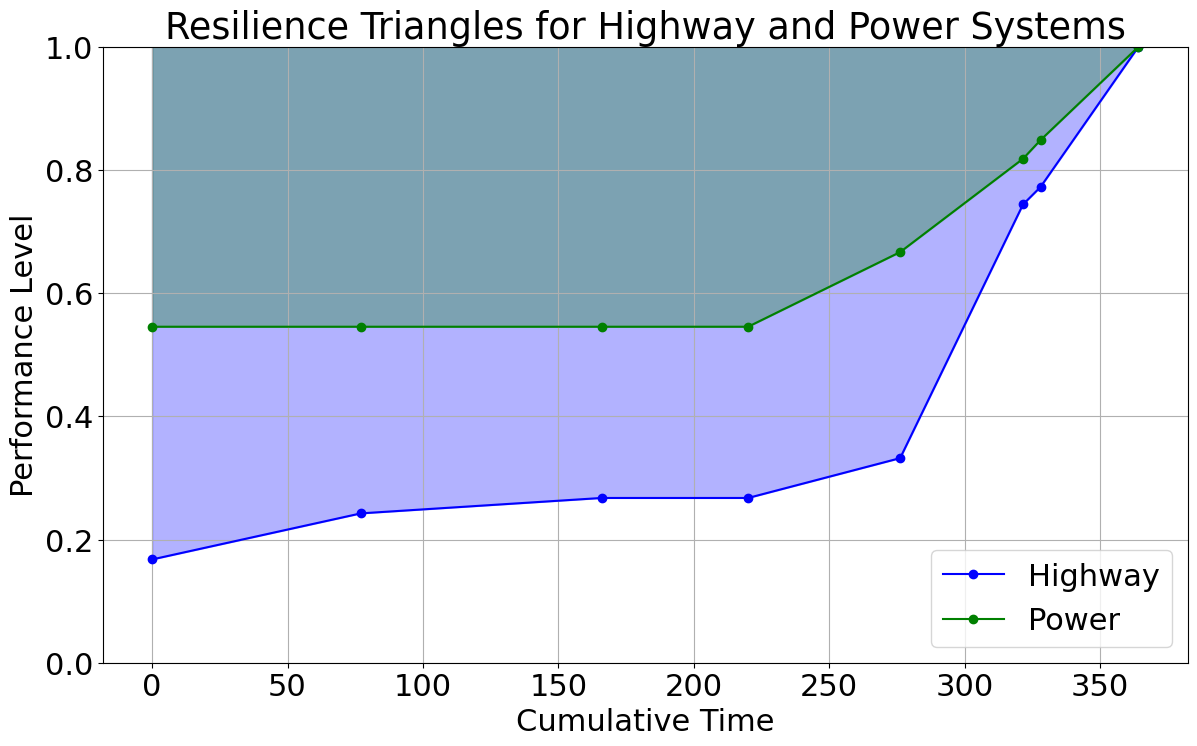

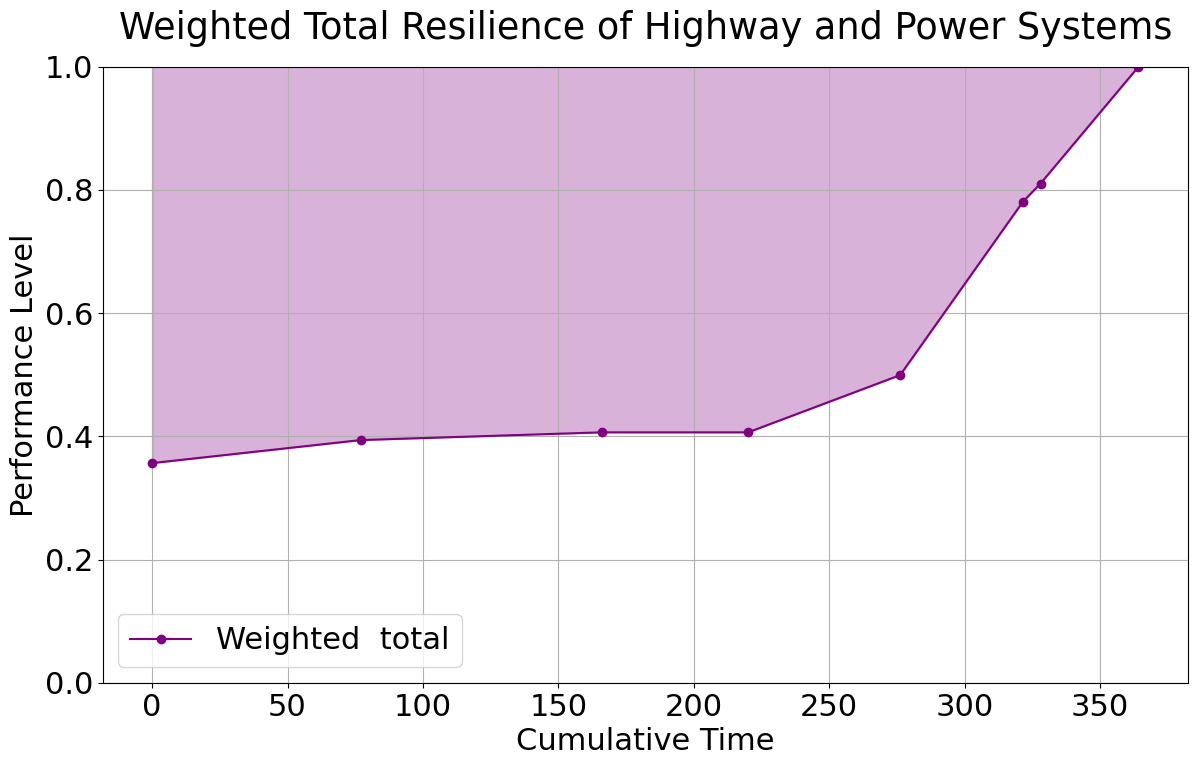

In [39]:
seq_SENS3_roadpri,roadres_SENS3_roadpri,powerres_SENS3_roadpri,time_SENS3_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS3",'evalRoadPrioritySENS3',True)

eval


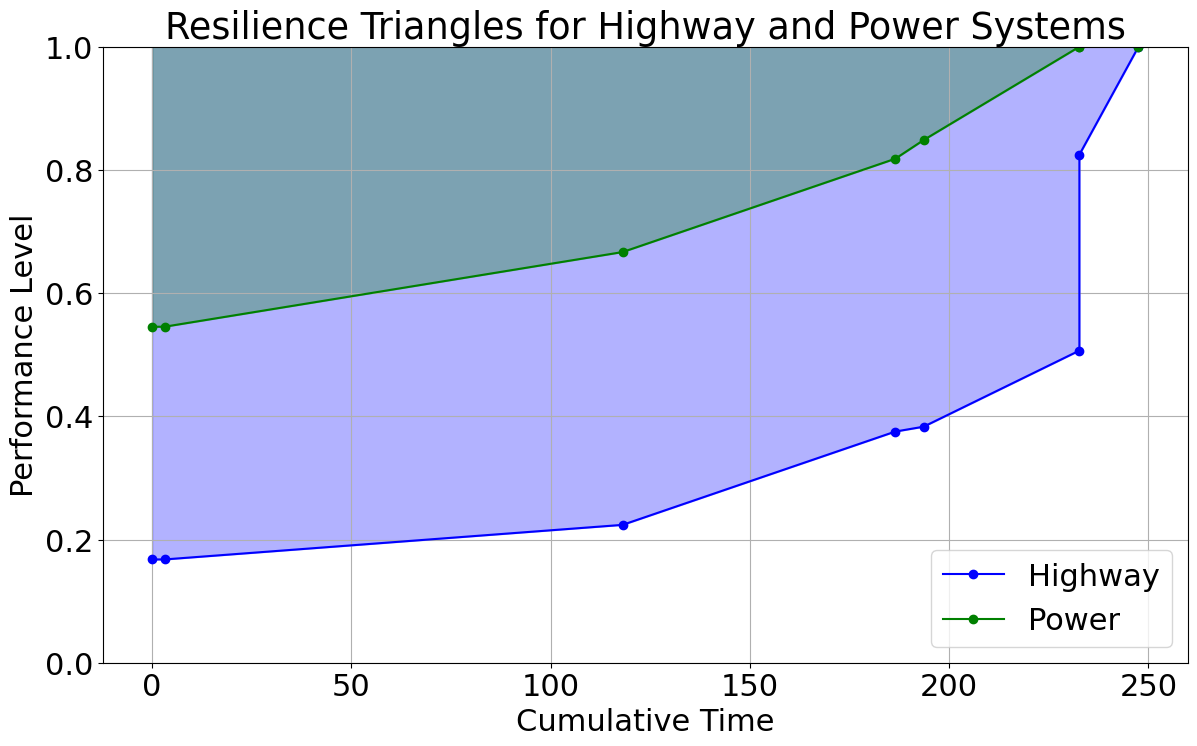

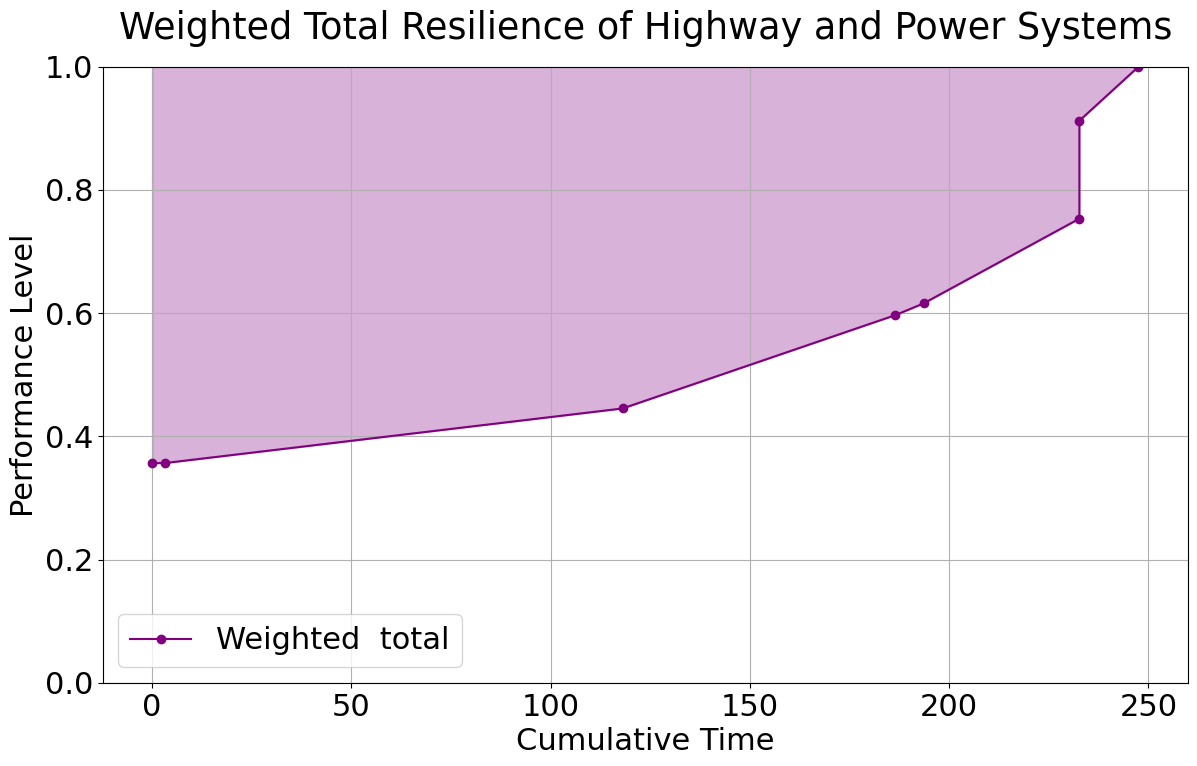

In [40]:
seq_SENS3_powerpri,roadres_SENS3_powerpri,powerres_SENS3_powerpri,time_SENS3_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS3",'evalPowerPrioritySENS3',True)

In [41]:
power_road_factor=0.5

Sensitivity #4
Interdependency Pattern like where the interdependenct location is

Initial population:
[32, 15, (11, 14), 11, (9, 10), 17, 28]
[11, 15, 28, (11, 14), 17, (9, 10), 32]
[(9, 10), 15, 28, 32, 11, (11, 14), 17]
[28, 32, 15, 17, (9, 10), 11, (11, 14)]
[15, 11, (11, 14), 17, 28, (9, 10), 32]
gen	nevals	avg    	min                  	max                 
0  	100   	302.033	(135.13615957290781,)	(593.2707577435714,)
1  	51    	212.772	(135.13615957290781,)	(480.7124747859214,)
2  	62    	194.877	(124.90505202713521,)	(551.4453745533547,)
3  	67    	182.942	(121.97039310621818,)	(551.4453745533547,)
4  	54    	157.356	(121.97039310621818,)	(512.8883753576787,)
5  	56    	149.491	(121.97039310621818,)	(384.05092536196963,)
6  	54    	138.633	(92.31711924792697,) 	(384.05092536196963,)
7  	65    	129.276	(92.31711924792697,) 	(337.1041222240243,) 
8  	65    	140.361	(92.31711924792697,) 	(586.0673977840142,) 
9  	55    	118.521	(92.31711924792697,) 	(321.95186002010064,)
10 	66    	112.367	(92.31711924792697,) 	(471.027529063731,)  
11 	63    	118.609	(92.3171192

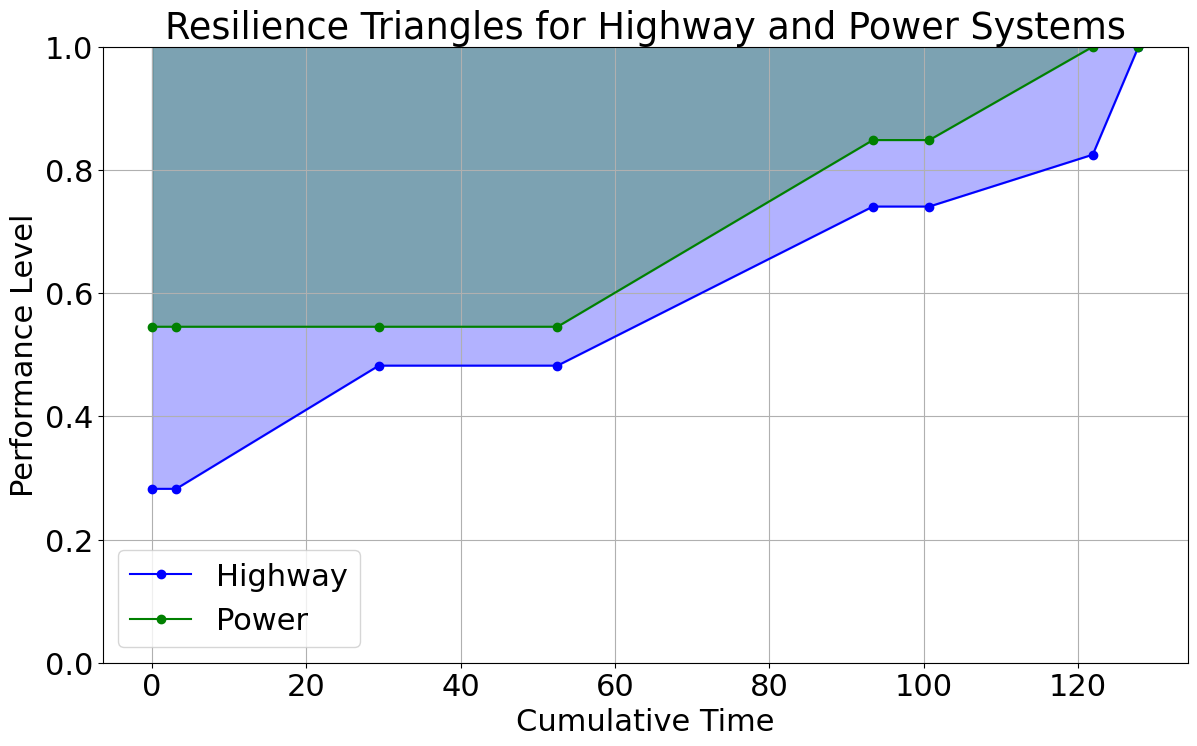

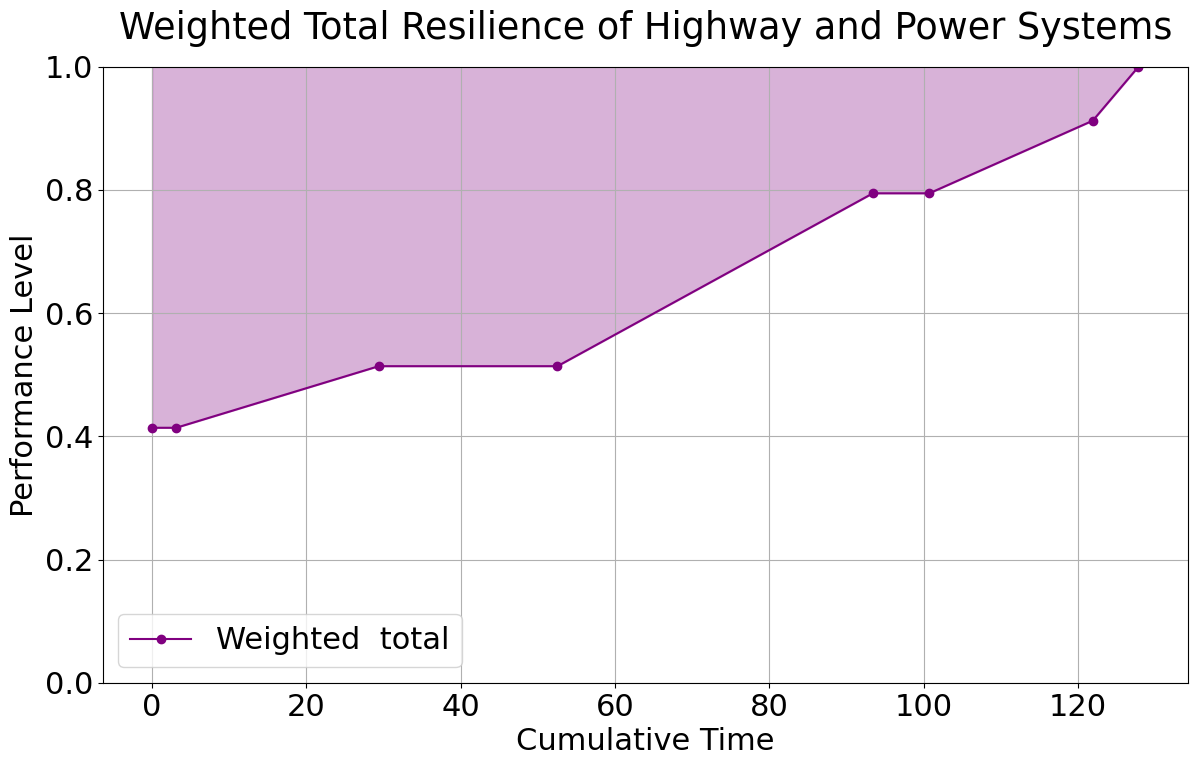

In [42]:
seq_SENS4_opt,roadres_SENS4_opt,powerres_SENS4_opt,time_SENS4_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #4, traffic light location",'SENS4',True)


In [43]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS4",'optPowerSENS4',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS4",'optRoadSENS4',False)[0]

Initial population:
[32, 11, 17, 28, 15]
[28, 15, 32, 11, 17]
[28, 11, 15, 32, 17]
[15, 28, 17, 32, 11]
[11, 17, 15, 28, 32]
gen	nevals	avg    	min                 	max                  
0  	100   	110.613	(57.45446461867888,)	(213.73513733829822,)
1  	57    	78.41  	(56.95557993525446,)	(186.11660579329367,)
2  	62    	68.253 	(56.95557993525446,)	(118.41145948080991,)
3  	61    	62.7782	(56.95557993525446,)	(129.49355129668317,)
4  	62    	61.2122	(56.95557993525446,)	(153.84530612101014,)
5  	58    	62.2216	(56.95557993525446,)	(129.49355129668317,)
6  	59    	60.3504	(56.95557993525446,)	(173.4165033008856,) 
7  	71    	58.8817	(56.95557993525446,)	(122.69719269986201,)
8  	56    	59.3235	(56.95557993525446,)	(114.8137201546396,) 
9  	63    	60.8721	(56.95557993525446,)	(114.8137201546396,) 
10 	61    	59.4571	(56.95557993525446,)	(114.8137201546396,) 
11 	63    	61.4947	(56.95557993525446,)	(152.27283663493967,)
12 	54    	61.813 	(56.95557993525446,)	(149.06634944891167,)
13 	56 

eval


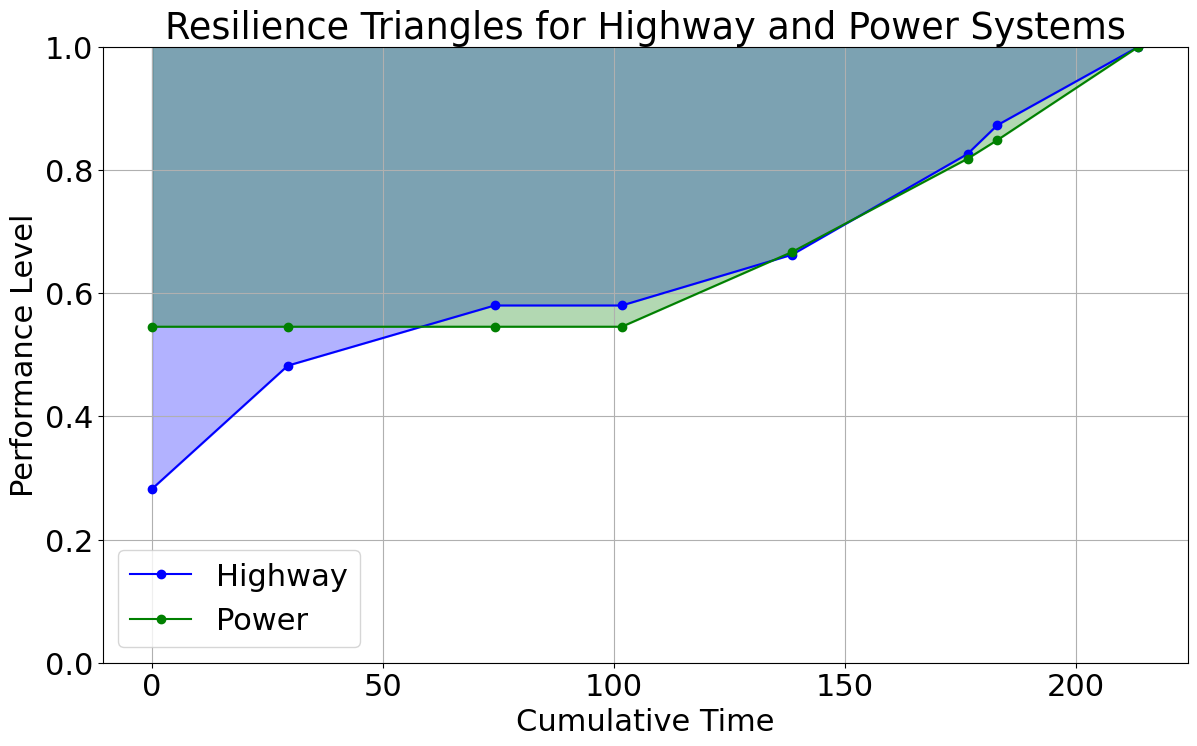

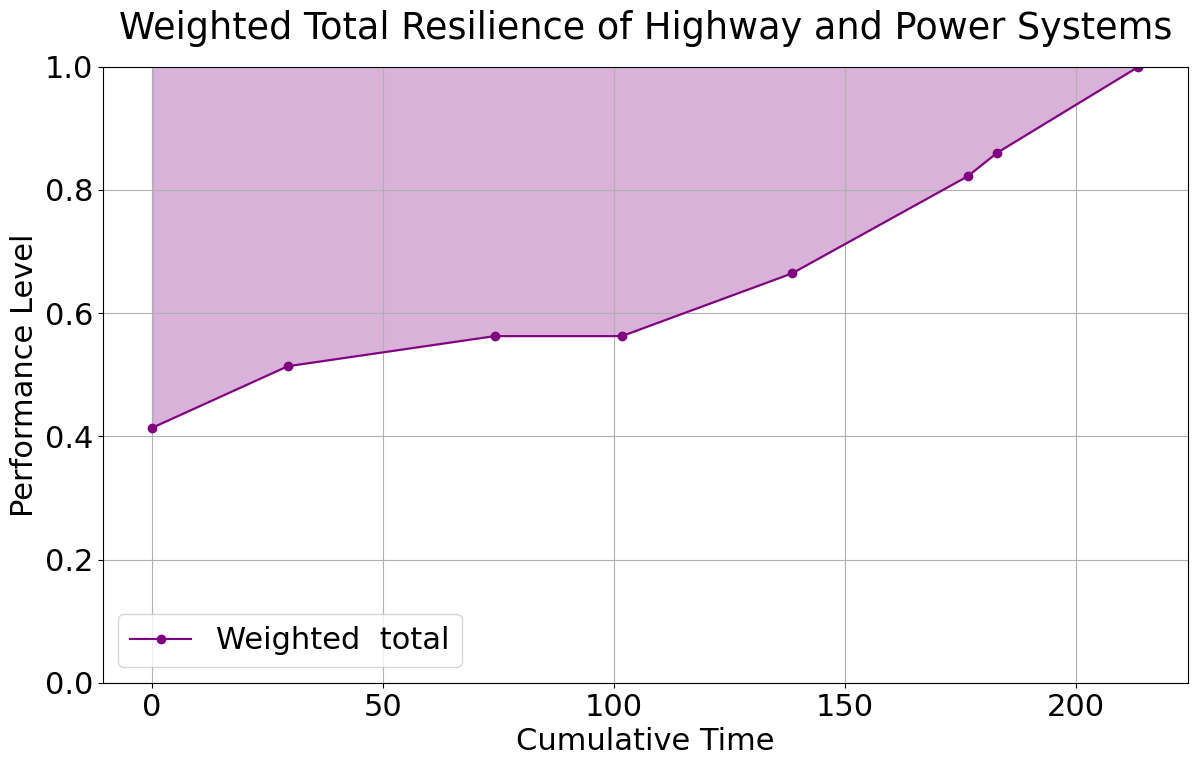

In [44]:
seq_SENS4_roadpri,roadres_SENS4_roadpri,powerres_SENS4_roadpri,time_SENS4_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS4",'evalRoadPrioritySENS4',True)


eval


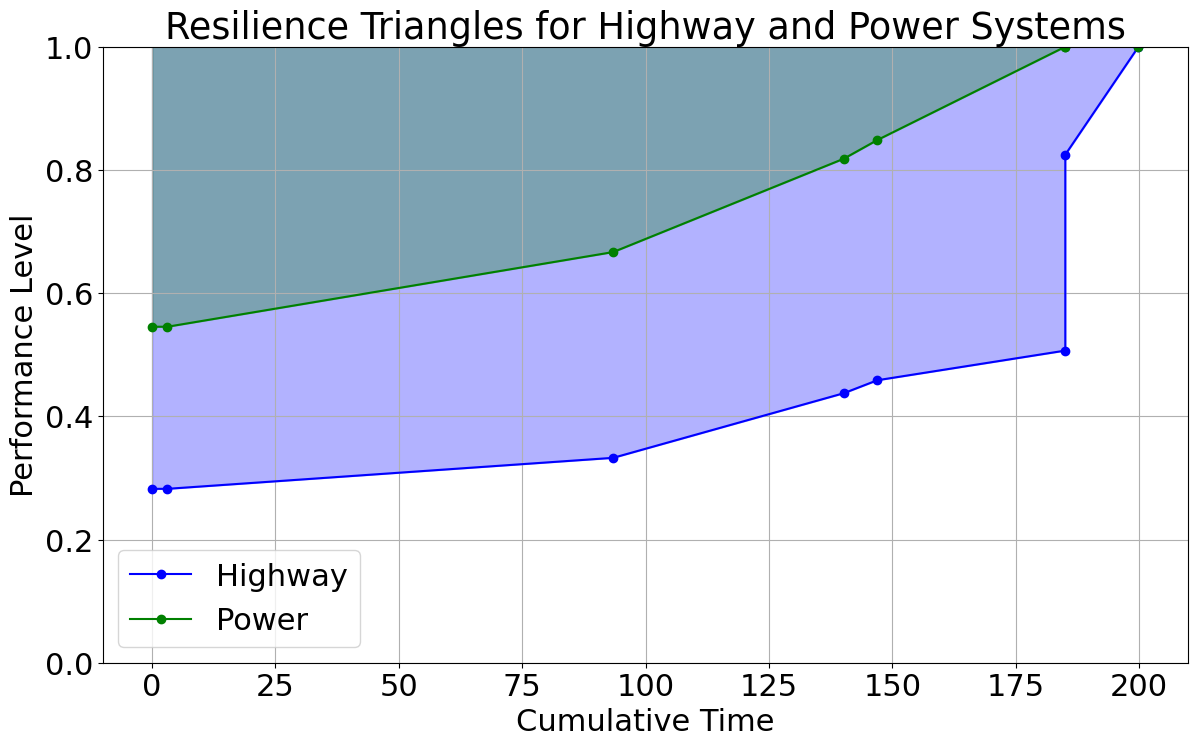

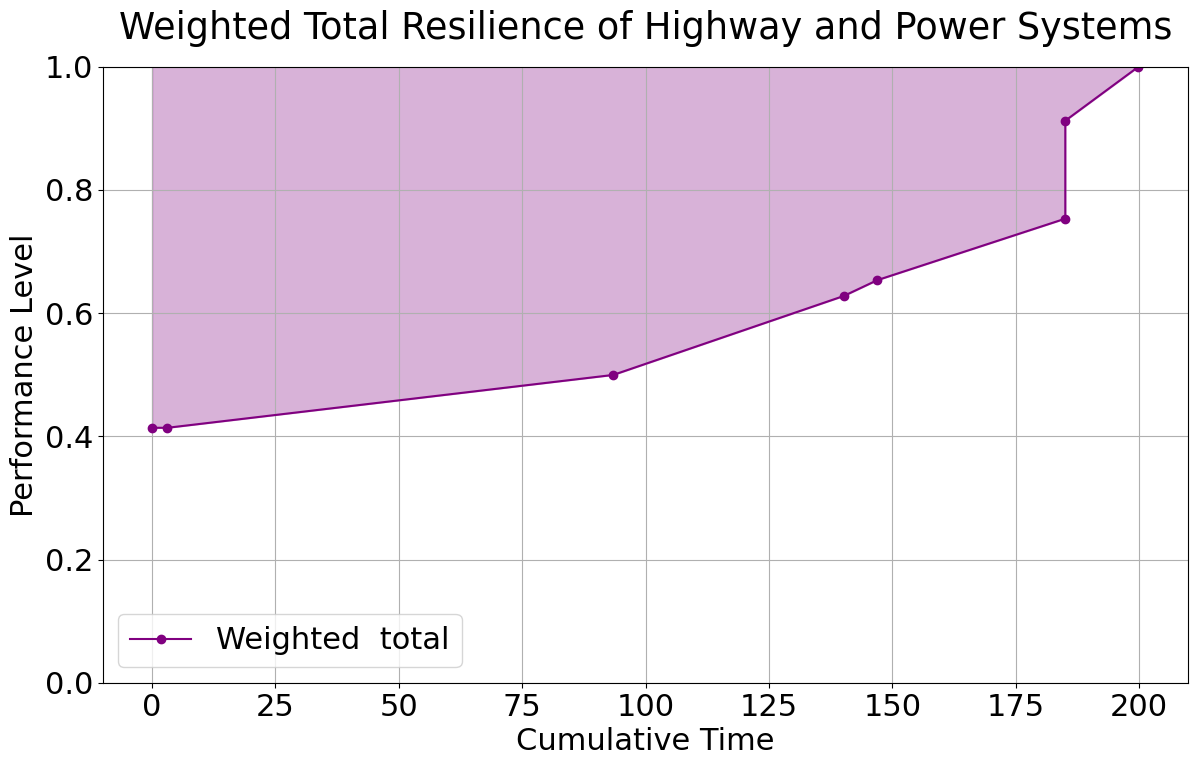

In [45]:
seq_SENS4_powerpri,roadres_SENS4_powerpri,powerres_SENS4_powerpri,time_SENS4_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS4",'evalPowerPrioritySENS4',True)

Sensitivity #5
One directional interdependency

Initial population:
[28, 15, (9, 10), (11, 14), 11, 32, 17]
[11, (9, 10), 15, 32, (11, 14), 28, 17]
[15, (11, 14), 11, 17, (9, 10), 28, 32]
[17, 15, 32, (9, 10), (11, 14), 28, 11]
[32, 11, 15, (9, 10), (11, 14), 28, 17]
gen	nevals	avg    	min                 	max                 
0  	100   	143.847	(51.87837009978125,)	(269.3022449914778,)
1  	50    	90.6272	(49.08545788592989,)	(214.64989295722623,)
2  	64    	77.0196	(49.08545788592989,)	(218.77596735740127,)
3  	67    	66.4711	(49.08545788592989,)	(209.11948271648743,)
4  	59    	56.4065	(48.40771284532249,)	(203.49912133284823,)
5  	58    	57.6479	(48.40771284532249,)	(173.1532395846716,) 
6  	55    	63.4829	(48.40771284532249,)	(189.94544514976056,)
7  	65    	65.5175	(48.40771284532249,)	(199.2142823215225,) 
8  	61    	53.6262	(48.40771284532249,)	(197.64345636193377,)
9  	65    	53.0465	(48.40771284532249,)	(145.7760178443487,) 
10 	61    	55.212 	(48.40771284532249,)	(166.6679676146241,) 
11 	65    	58.0585	(48.40771284532249,

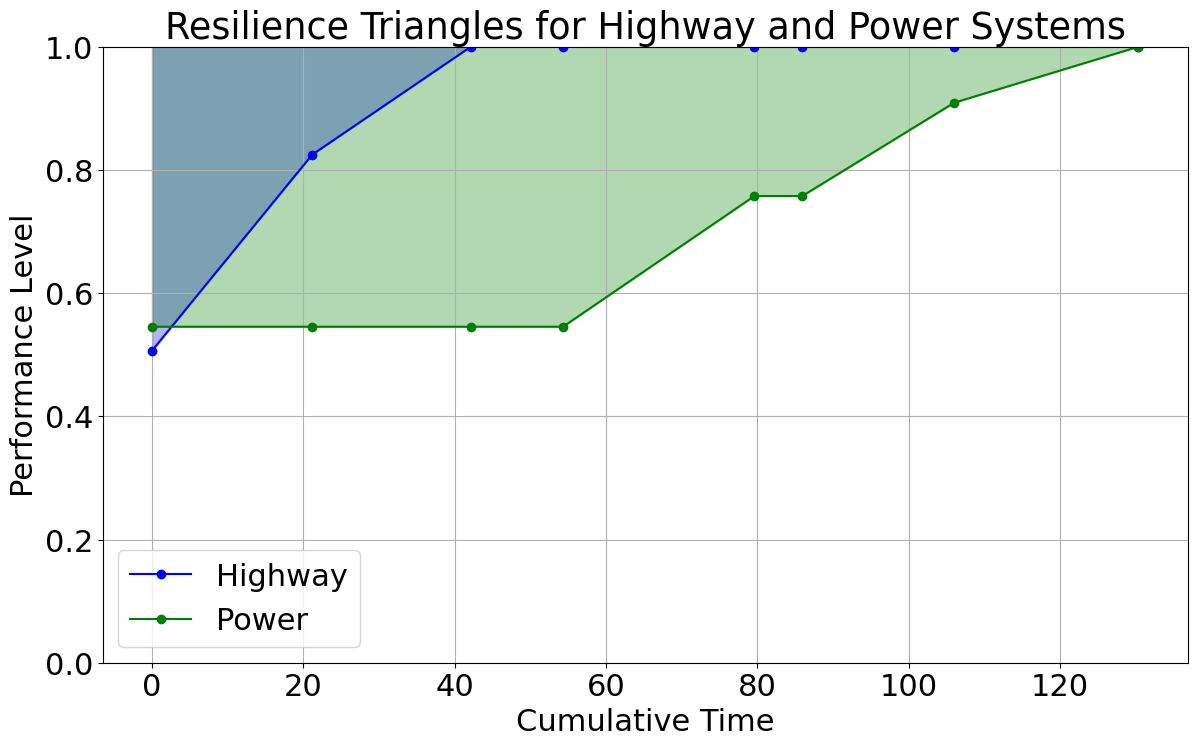

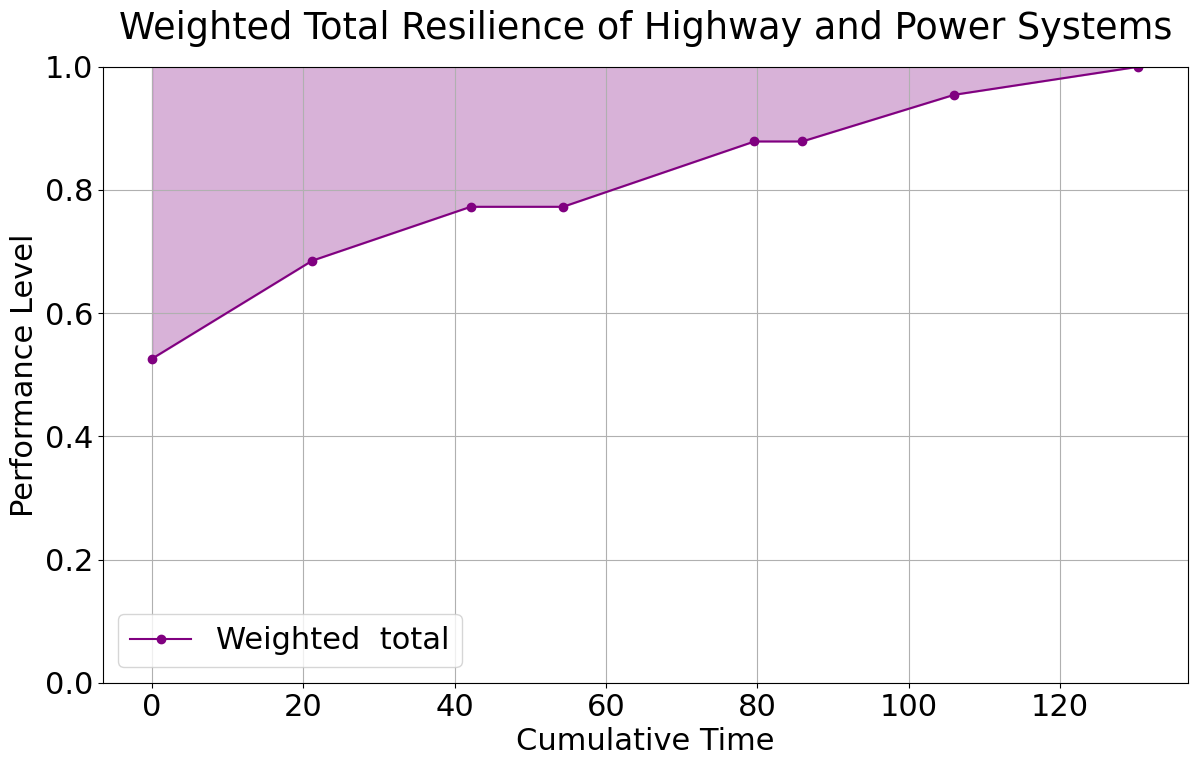

In [46]:
power_road_factor=1.0
seq_SENS5_opt,roadres_SENS5_opt,powerres_SENS5_opt,time_SENS5_opt=run_model(sequence,True,result_folder,"This is SENSITIVITY #5, one directional interdependency",'SENS5',True)

In [47]:

powers_only=[11,17,15,28,32]
roads_only=[(9,10),(11,14)]
power_ans=run_model(powers_only,True,result_folder,"This is optimal Power only SENS5",'optPowerSENS5',False)[0]
roads_ans=run_model(roads_only,True,result_folder,"This is optimal Road only SENS5",'optRoadSENS5',False)[0]


Initial population:
[32, 11, 15, 17, 28]
[32, 28, 15, 11, 17]
[11, 17, 32, 28, 15]
[28, 17, 15, 11, 32]
[32, 28, 17, 11, 15]
gen	nevals	avg    	min                 	max                 
0  	100   	36.6212	(20.48259596944059,)	(59.43118931597982,)
1  	52    	25.6178	(20.48259596944059,)	(48.32194135656757,)
2  	64    	22.0496	(20.48259596944059,)	(38.81869861967068,)
3  	66    	21.8984	(20.48259596944059,)	(35.545203804482796,)
4  	64    	22.2319	(20.48259596944059,)	(59.43118931597982,) 
5  	66    	21.947 	(20.48259596944059,)	(40.07310245089391,) 
6  	55    	21.5884	(20.48259596944059,)	(38.81869861967068,) 
7  	54    	21.2517	(20.48259596944059,)	(33.396021901961774,)
8  	59    	21.4729	(20.48259596944059,)	(37.80576794842774,) 
9  	64    	22.0079	(20.48259596944059,)	(58.54833444921097,) 
10 	62    	22.5793	(20.48259596944059,)	(59.43118931597982,) 
11 	63    	22.5613	(20.48259596944059,)	(43.91219531010161,) 
12 	50    	21.9514	(20.48259596944059,)	(42.14274454295586,) 
13 	61    	

eval


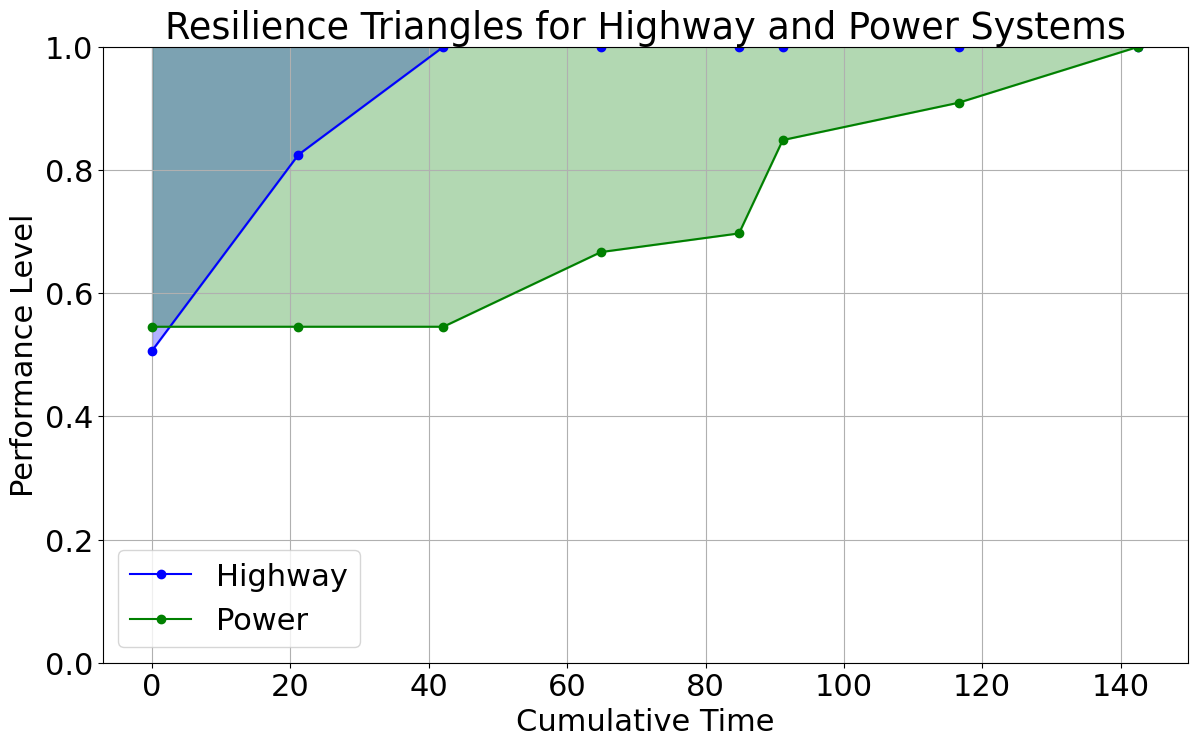

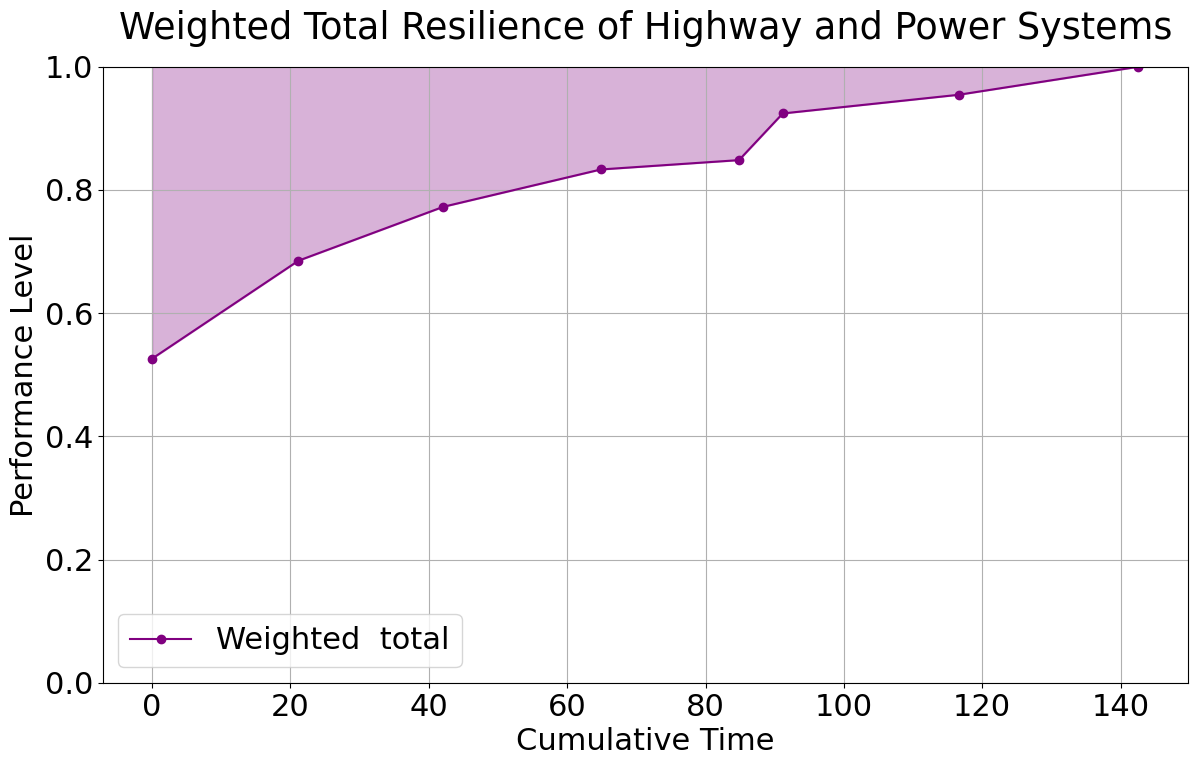

In [48]:
seq_SENS5_roadpri,roadres_SENS5_roadpri,powerres_SENS5_roadpri,time_SENS5_roadpri=run_model(roads_ans+power_ans,True,result_folder,"This is Road priority SENS5",'evalRoadPrioritySENS5',True)


eval


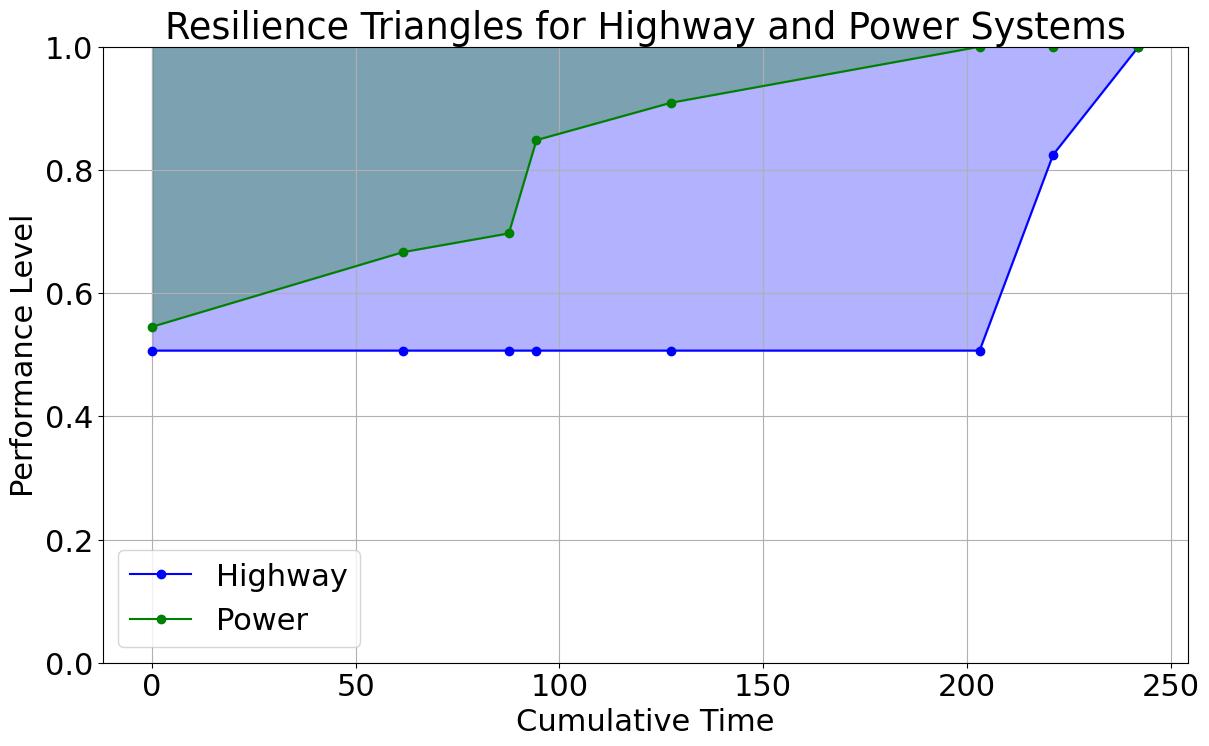

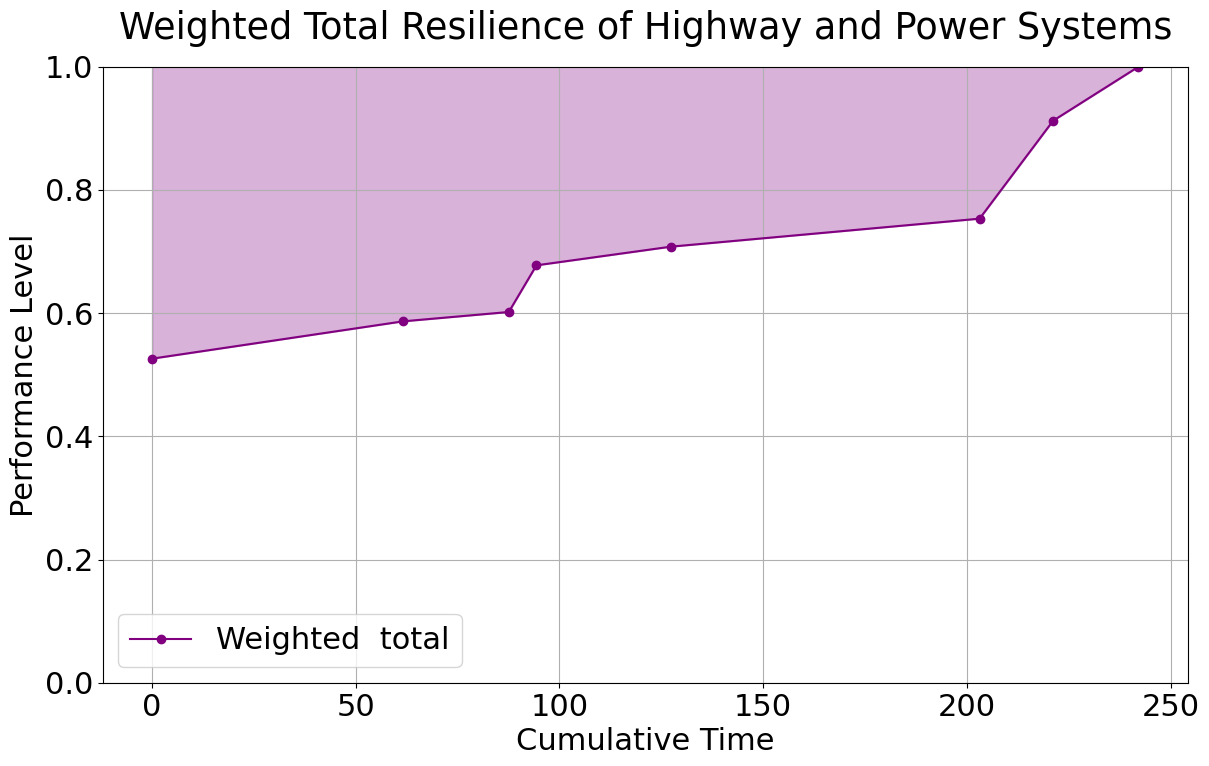

In [49]:
seq_SENS5_powerpri,roadres_SENS5_powerpri,powerres_SENS5_powerpri,time_SENS5_powerpri=run_model(power_ans+roads_ans,True,result_folder,"This is Power priority SENS5",'evalPowerPrioritySENS5',True)

In [50]:
power_road_factor=0.5

Now This Generate some comparison sequence:
1. Compare default vs random
2. Compare default vs 2 priorities
3. SENS more broken compare with 2 priorities
4. SENS More severity vs 2 priorities
5. SENS default vs single dir   

Below are the hand made for QA purposes

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.

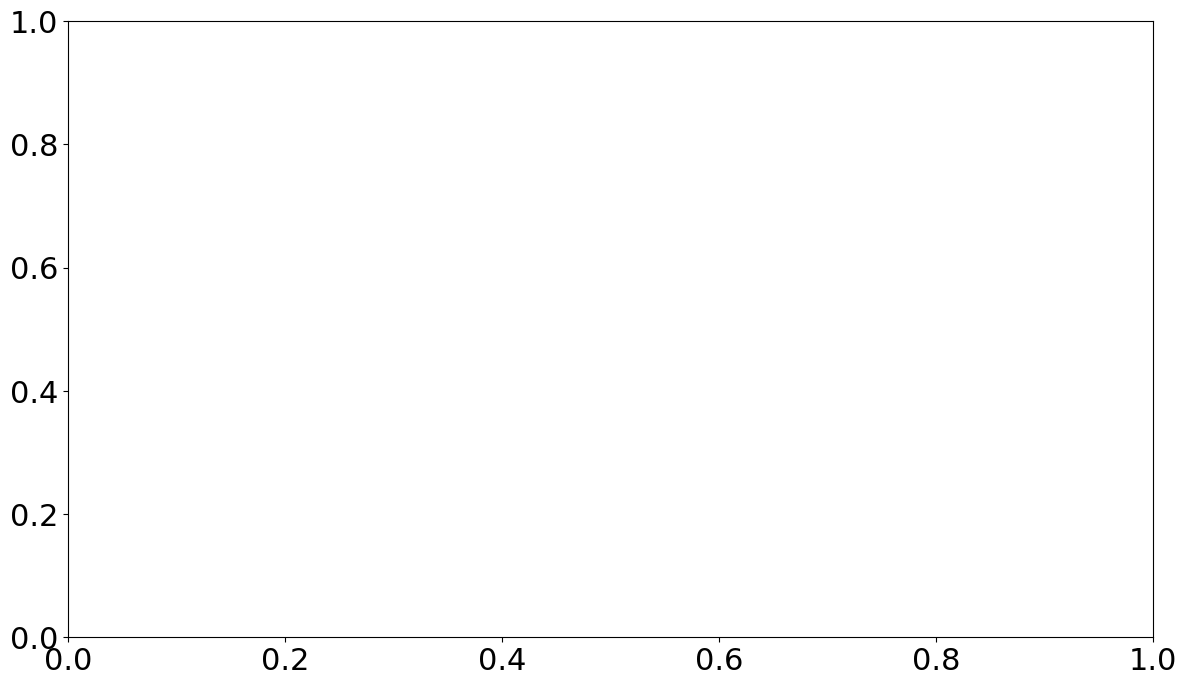

In [51]:
from plot_resilience import plot_triangles_compare2
plot_triangles_compare2(seq_default_opt, seq_default_random,time_default_opt,time_default_random,'optimal','random','compare_random_default')

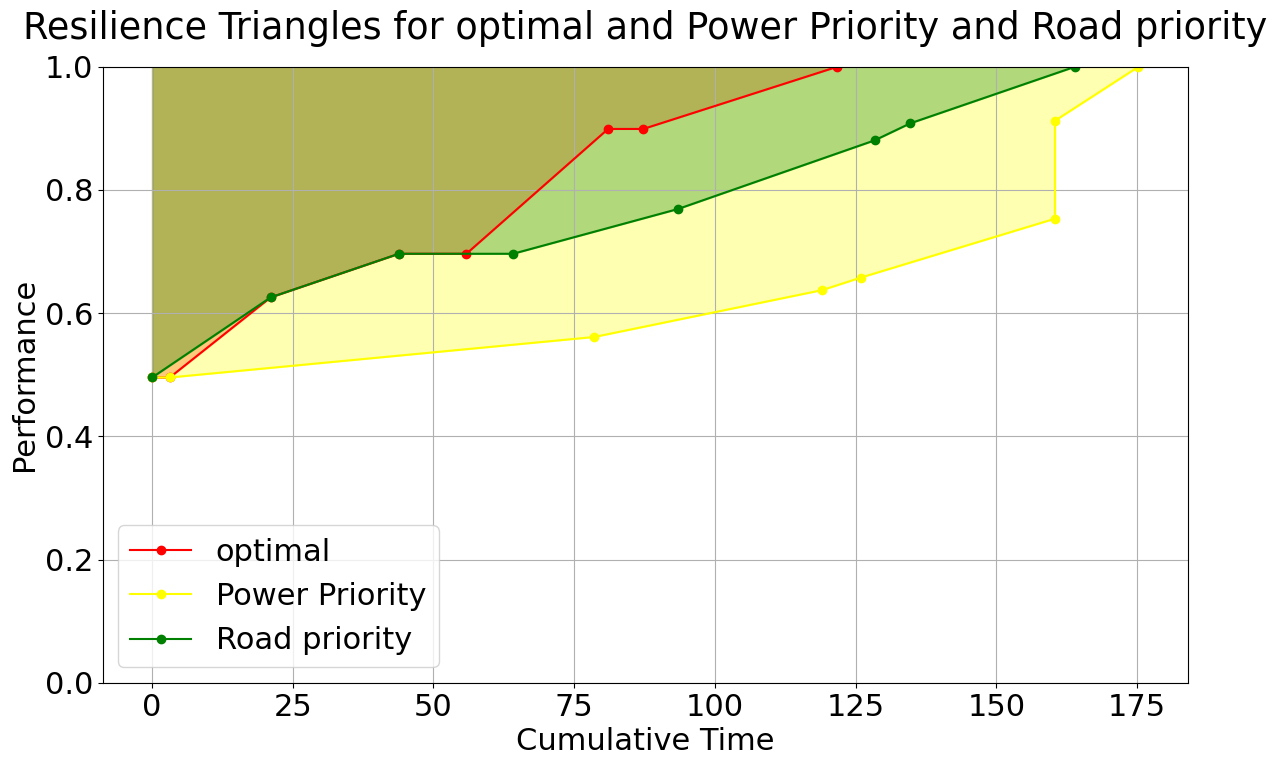

In [100]:
from plot_resilience import plot_triangles_compare3
plot_triangles_compare3(seq_default_opt, seq_default_powerpri,seq_default_roadpri,time_default_opt,time_default_powerpri,time_default_roadpri,'optimal','Power Priority','Road priority','compare_deault_priority_default')

More links

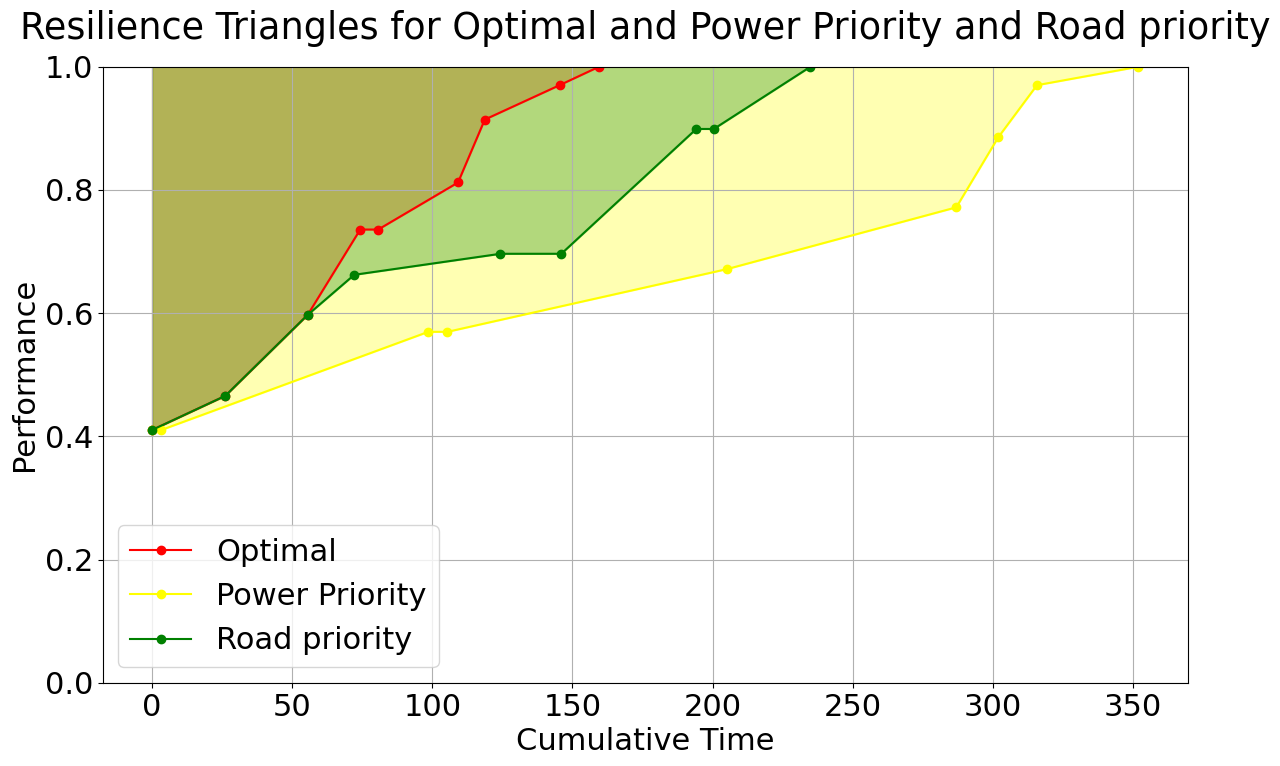

In [1]:
from plot_resilience import plot_triangles_compare3

plot_triangles_compare3(seq_SENS1_opt, seq_SENS1_powerpri,seq_SENS1_roadpri,time_default_opt,time_SENS1_powerpri,time_SENS1_roadpri,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

change in point

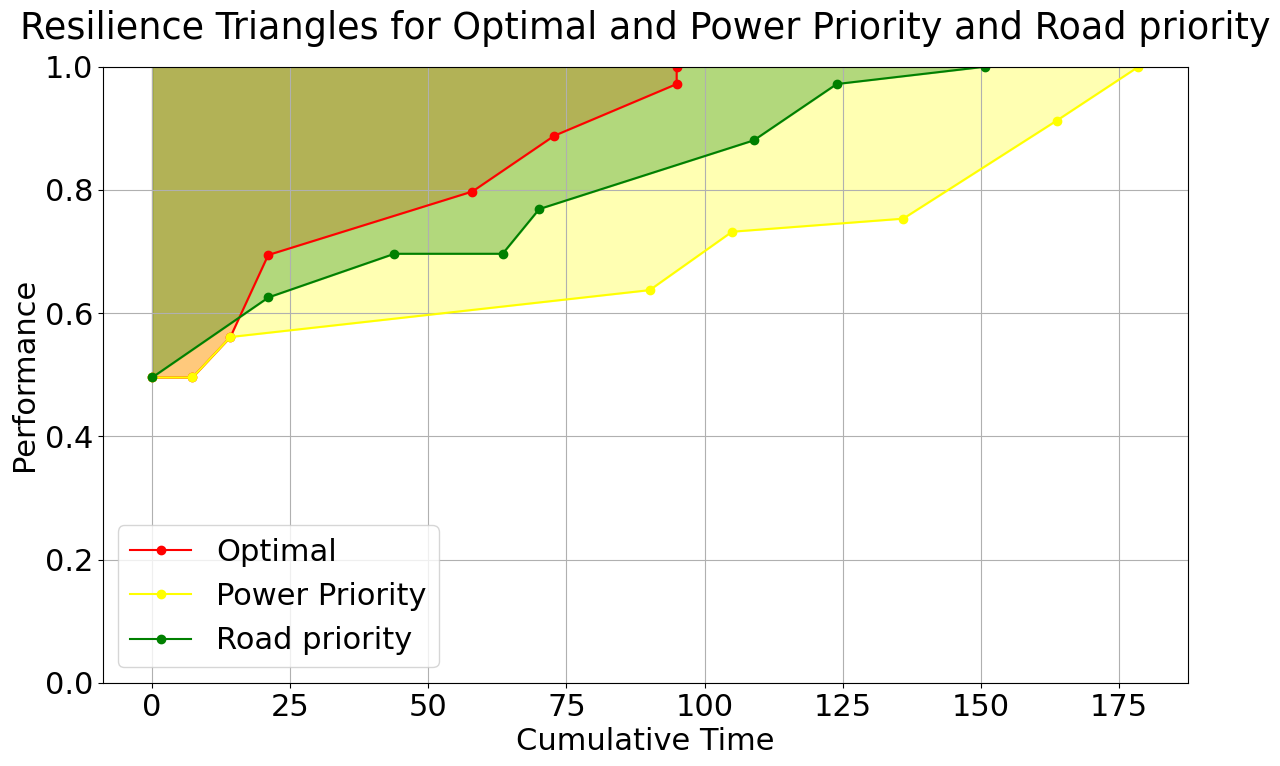

In [102]:
from plot_resilience import plot_triangles_compare3

plot_triangles_compare3(seq_default_opt, seq_SENS2_powerpri,seq_SENS2_roadpri,time_default_opt,time_SENS2_powerpri,time_SENS2_roadpri,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

move the connection around

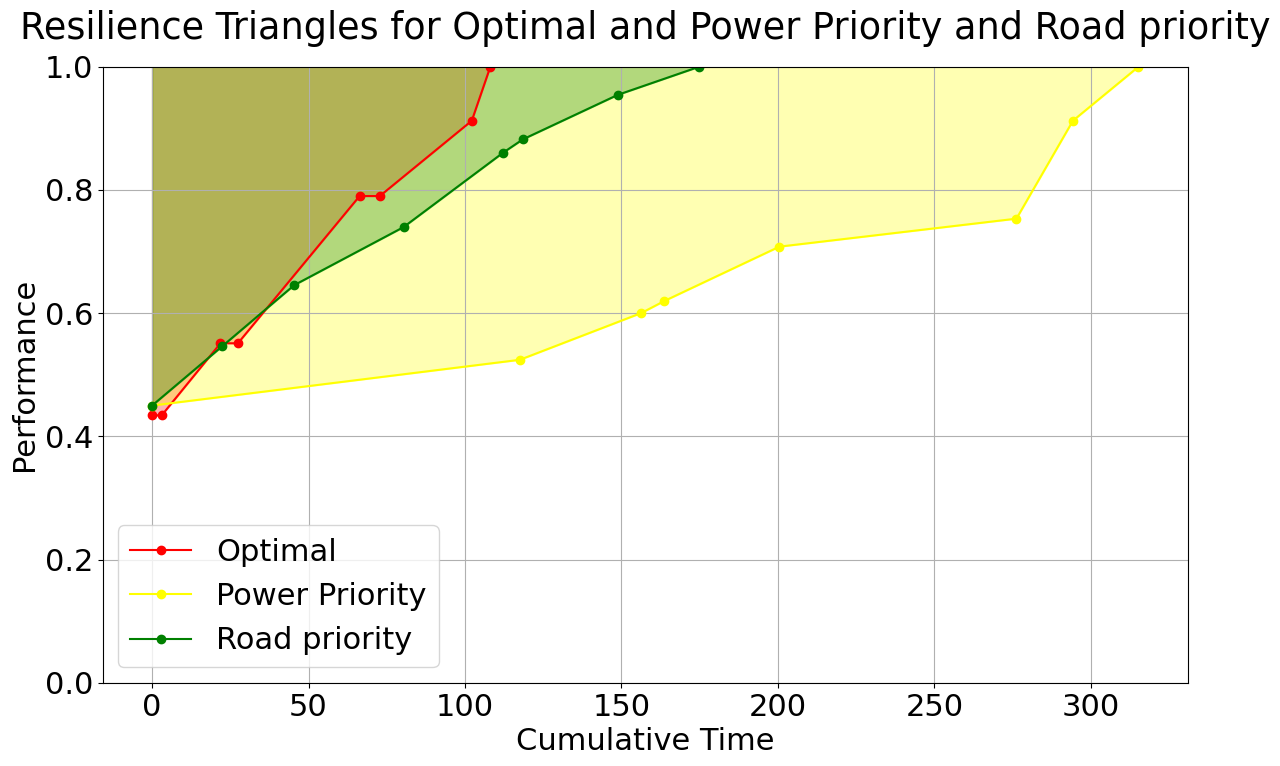

In [103]:
from plot_resilience import plot_triangles_compare3
plot_triangles_compare3(seq_SENS4_opt, seq_SENS4_powerpri,seq_SENS4_roadpri,time_SENS4_opt,time_SENS4_powerpri,time_SENS4_roadpri,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

More severity

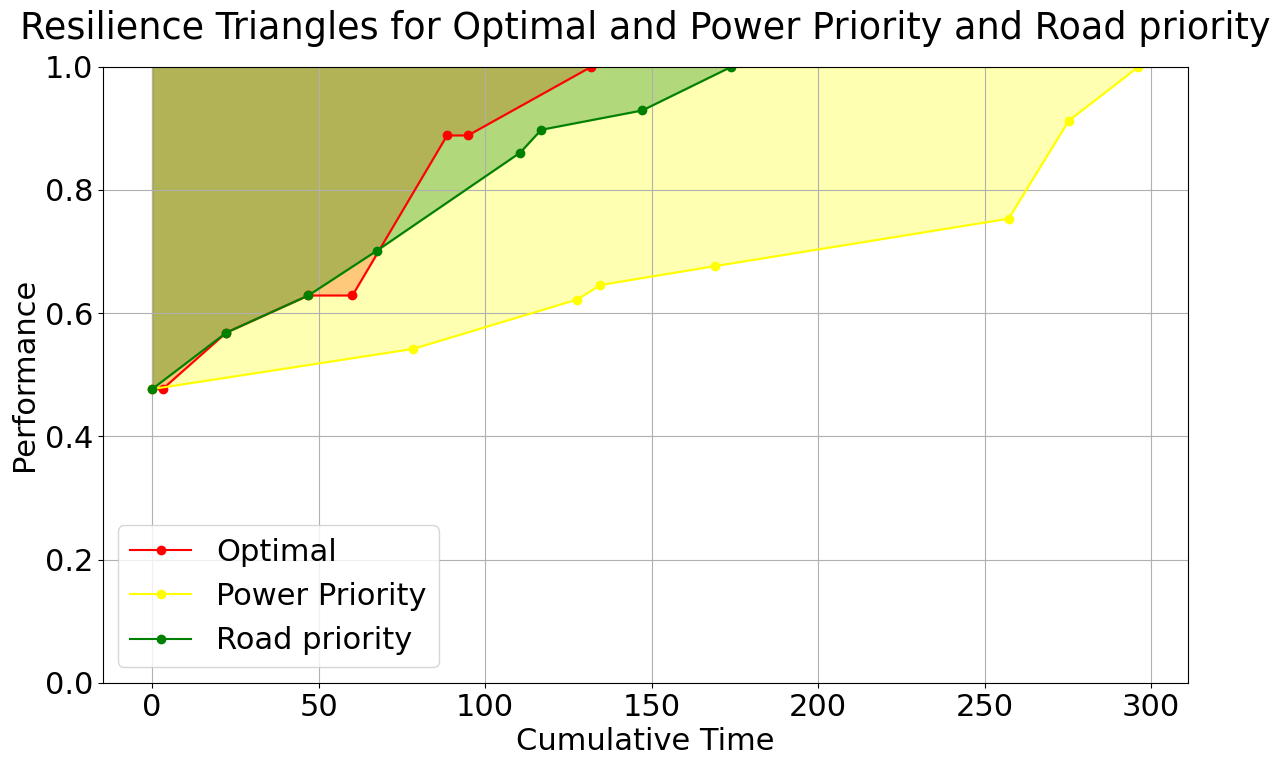

In [9]:
from plot_resilience import plot_triangles_compare3

plot_triangles_compare3(seq_SENS3_opt, seq_SENS3_powerpri,seq_SENS3_roadpri,time_SENS3_opt,t,time_SENS3_powerpri,time_SENS3_roadpri,'Optimal','Power Priority','Road priority','compare_deault_priority_default')

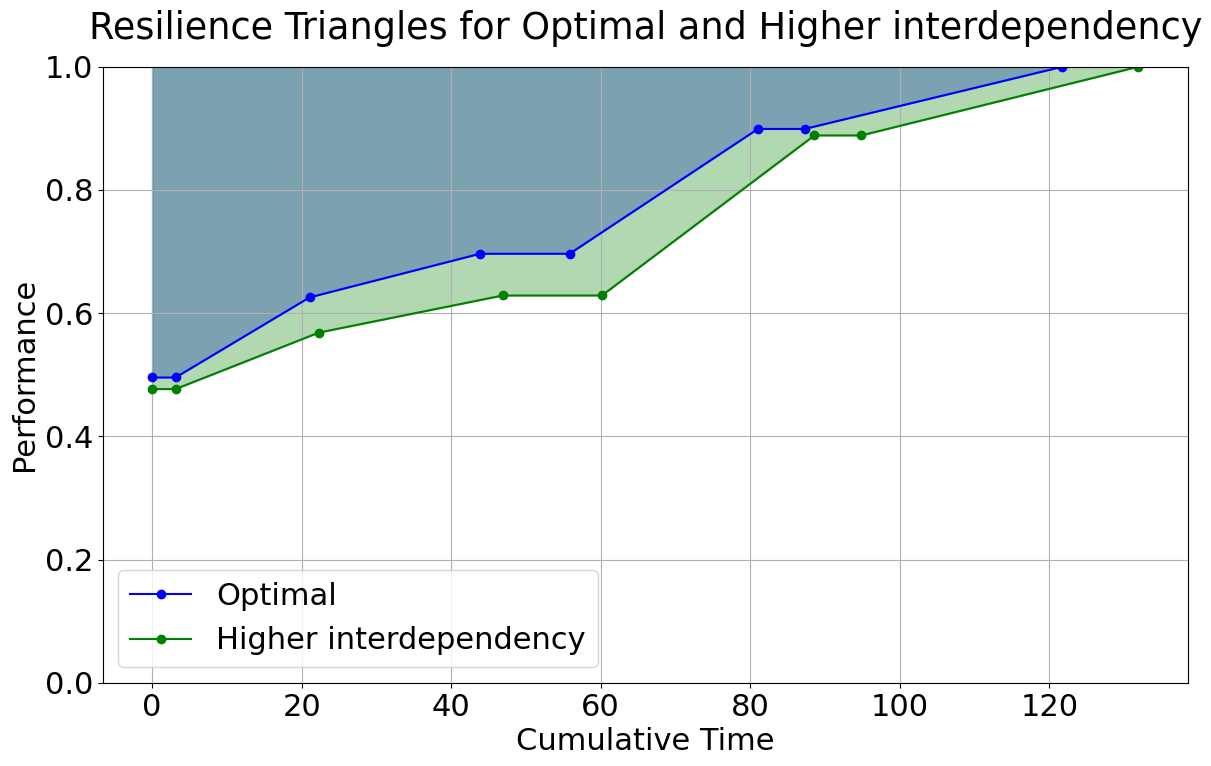

In [11]:
from plot_resilience import plot_triangles_compare2
plot_triangles_compare2(seq_default_opt, seq_SENS3_opt,time_default_opt,time_SENS3_opt,'Optimal','Higher interdependency','compare_higherinterd_default')

Put back sensitivity 5

In [105]:
power_road_factor=0.5
run_model(seq_SENS5_opt,True,result_folder,"This is for sens5 on regular factor",'evalSENS5',False)

eval



([17, (9, 10), 15, (11, 14), 11, 32, 28],
 [0.44553396095539116,
  0.44553396095539116,
  0.7056831520794121,
  0.7056831520794121,
  0.847252092630669,
  0.949464697637762,
  0.949464697637762],
 [0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.5454545454545454,
  0.8484848484848485,
  0.8484848484848485],
 [3.133136, 17.931908, 16.588904, 19.351115, 37.174971, 6.258539, 34.487867])

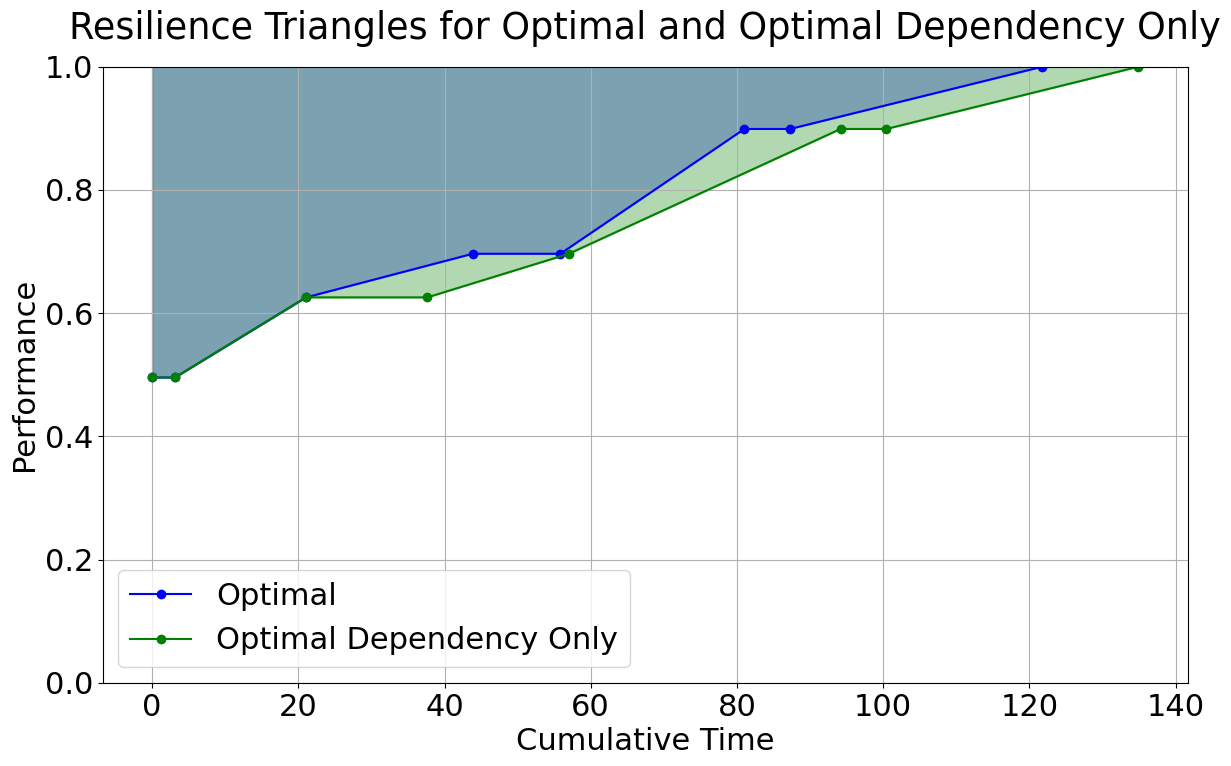

In [106]:
from plot_resilience import plot_triangles_compare2
plot_triangles_compare2(seq_default_opt, seq_SENS5_opt,time_default_opt,time_SENS5_opt,'Optimal','Optimal Dependency Only','compare_one-dir_default')

Sensitivity #X not used
Demand pattern, like 50% demand in at time 0 and gradual recover? hard to design
